<a id="title"></a>
# Calculating WFC3 Zeropoints with STSynphot
<hr>
## Learning Goals 
By the end of this tutorial, you will:
- Calculate zeropoints and other photometric properties using `stsynphot`.
- Create, plot, and save 'total system throughput' tables.

## Table of Contents
[Introduction](#intro) <br>
[1. Imports](#imports) <br>
[2. Download throughput tables and define variables](#envvar) <br>
[3. Set up the 'obsmode' string](#inps) <br>
[4. Basic usage for a single 'obsmode'](#usage) <br>
[5. Compute zeropoints and other photometric properties](#zps) <br>
[6. Iterate over multiple 'obsmodes'](#iterate) <br>
[7. Create and plot 'total system throughput' tables](#curves) <br>
[8. Conclusions](#conclusions) <br>
[Additional Resources](#resources) <br>
[About the Notebook](#about) <br>
[Citations](#cite) <br>

<a id="intro"></a>
## Introduction
This notebook shows how to calculate photometric zeropoints using the Python package `stsynphot` for any WFC3 detector, filter, date, or aperture. This tutorial is especially useful for calculating Vegamag zeropoints, which require an input spectrum. The notebook is also useful for computing time-dependent WFC3/UVIS zeropoints for any observation date, as the values listed in [WFC3 ISR 2021-04](https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/wfc3/documentation/instrument-science-reports-isrs/_documents/2021/WFC3_ISR_2021-04.pdf) are defined for the reference epoch. As of mid-2021, the WFC3/IR zeropoints are not time-dependent.

More documentation on `stsynphot` is available [here](https://stsynphot.readthedocs.io/en/latest/index.html). Using `stsynphot` requires downloading the throughput curves for the HST instruments and optical path.  One method of doing this is shown in [Section 2](#envvar).  More information on the throughput tables can be found [here](https://www.stsci.edu/hst/instrumentation/reference-data-for-calibration-and-tools/synphot-throughput-tables).

<a id="imports"></a>
## 1. Imports

This notebook assumes you have created the virtual environment in [WFC3 notebooks'](https://github.com/spacetelescope/hst_notebooks/blob/main/notebooks/WFC3/README.md) installation instructions.

We import:
- *os* for setting environment variables
- *tarfile* for extracting a .tar archive

- *numpy* for handling array functions
- *matplotlib.pyplot* for plotting data
- *astropy* for astronomy related functions

- *synphot* and *stsynphot* for evaluating synthetic photometry

We will need to set the `PYSYN_CDBS` environment variable *before* importing stsynphot. We will also create a custom Vega spectrum, as the `stsynphot` will supercede the usual `synphot` functionality regarding the Vega spectrum and would otherwise require a downloaded copy of the spectrum to be provided.

In [1]:
import os
import tarfile

import numpy as np
import matplotlib.pyplot as plt

from astropy.table import Table

from synphot import Observation

<a class="anchor" id="envvar"></a>
## 2. Download throughput tables and define variables

This section obtains the WFC3 throughput component tables for use with `stsynphot`. This step only needs to be done once. If these reference files have already been downloaded, this section can be skipped.

In [2]:
!curl -O https://archive.stsci.edu/hlsps/reference-atlases/hlsp_reference-atlases_hst_multi_everything_multi_v11_sed.tar

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

  0  796M    0 4064k    0     0  3203k      0  0:04:14  0:00:01  0:04:13 3202k

  1  796M    1 8384k    0     0  3673k      0  0:03:41  0:00:02  0:03:39 3672k

  1  796M    1  9.8M    0     0  3094k      0  0:04:23  0:00:03  0:04:20 3094k

  1  796M    1 10.9M    0     0  2626k      0  0:05:10  0:00:04  0:05:06 2626k

  1  796M    1 11.8M    0     0  2296k      0  0:05:55  0:00:05  0:05:50 2410k

  1  796M    1 12.4M    0     0  2024k      0  0:06:42  0:00:06  0:06:36 1726k

  1  796M    1 12.7M    0     0  1805k      0  0:07:31  0:00:07  0:07:24  946k

  1  796M    1 13.0M    0     0  1620k      0  0:08:23  0:00:08  0:08:15  657k

  1  796M    1 13.2M    0     0  1470k      0  0:09:14  0:00:09  0:09:05  481k

  1  796M    1 13.5M    0     0  1346k      0  0:10:05  0:00:10  0:09:55  350k

  1  796M    1 13.7M    0     0  1249k      0  0:10:52  0:00:11  0:10:41  275k

  1  796M    1 14.0M    0     0  1172k      0  0:11:35  0:00:12  0:11:23  260k

  1  796M    1 14.5M    0     0  1120k      0  0:12:07  0:00:13  0:11:54  294k

  1  796M    1 15.0M    0     0  1084k      0  0:12:31  0:00:14  0:12:17  368k

  1  796M    1 15.7M    0     0  1056k      0  0:12:51  0:00:15  0:12:36  454k

  2  796M    2 16.2M    0     0  1020k      0  0:13:19  0:00:16  0:13:03  502k

  2  796M    2 16.4M    0     0   977k      0  0:13:54  0:00:17  0:13:37  495k

  2  796M    2 16.7M    0     0   942k      0  0:14:25  0:00:18  0:14:07  469k

  2  796M    2 17.0M    0     0   908k      0  0:14:57  0:00:19  0:14:38  408k

  2  796M    2 17.5M    0     0   884k      0  0:15:21  0:00:20  0:15:01  360k

  2  796M    2 17.9M    0     0   865k      0  0:15:42  0:00:21  0:15:21  357k

  2  796M    2 18.5M    0     0   851k      0  0:15:57  0:00:22  0:15:35  416k

  2  796M    2 18.9M    0     0   832k      0  0:16:19  0:00:23  0:15:56  432k

  2  796M    2 19.3M    0     0   815k      0  0:16:40  0:00:24  0:16:16  454k

  2  796M    2 19.8M    0     0   803k      0  0:16:55  0:00:25  0:16:30  471k

  2  796M    2 20.3M    0     0   791k      0  0:17:09  0:00:26  0:16:43  483k

  2  796M    2 20.6M    0     0   776k      0  0:17:29  0:00:27  0:17:02  445k

  2  796M    2 21.0M    0     0   762k      0  0:17:48  0:00:28  0:17:20  438k

  2  796M    2 21.4M    0     0   750k      0  0:18:05  0:00:29  0:17:36  438k

  2  796M    2 21.9M    0     0   741k      0  0:18:19  0:00:30  0:17:49  432k

  2  796M    2 22.5M    0     0   738k      0  0:18:24  0:00:31  0:17:53  455k

  2  796M    2 23.3M    0     0   740k      0  0:18:21  0:00:32  0:17:49  540k

  3  796M    3 24.2M    0     0   746k      0  0:18:12  0:00:33  0:17:39  653k

  3  796M    3 25.2M    0     0   754k      0  0:18:00  0:00:34  0:17:26  778k

  3  796M    3 26.1M    0     0   760k      0  0:17:51  0:00:35  0:17:16  874k

  3  796M    3 26.9M    0     0   761k      0  0:17:50  0:00:36  0:17:14  906k

  3  796M    3 27.6M    0     0   759k      0  0:17:53  0:00:37  0:17:16  885k

  3  796M    3 28.4M    0     0   761k      0  0:17:50  0:00:38  0:17:12  860k

  3  796M    3 29.3M    0     0   765k      0  0:17:45  0:00:39  0:17:06  835k

  3  796M    3 30.1M    0     0   767k      0  0:17:42  0:00:40  0:17:02  816k

  3  796M    3 31.1M    0     0   773k      0  0:17:34  0:00:41  0:16:53  858k

  4  796M    4 32.1M    0     0   778k      0  0:17:27  0:00:42  0:16:45  921k

  4  796M    4 33.1M    0     0   784k      0  0:17:19  0:00:43  0:16:36  961k

  4  796M    4 33.9M    0     0   784k      0  0:17:18  0:00:44  0:16:34  940k

  4  796M    4 34.5M    0     0   782k      0  0:17:22  0:00:45  0:16:37  900k

  4  796M    4 34.9M    0     0   773k      0  0:17:33  0:00:46  0:16:47  777k

  4  796M    4 35.2M    0     0   763k      0  0:17:48  0:00:47  0:17:01  634k

  4  796M    4 35.6M    0     0   755k      0  0:17:59  0:00:48  0:17:11  506k

  4  796M    4 36.1M    0     0   750k      0  0:18:06  0:00:49  0:17:17  447k

  4  796M    4 36.5M    0     0   745k      0  0:18:13  0:00:50  0:17:23  414k

  4  796M    4 37.0M    0     0   739k      0  0:18:21  0:00:51  0:17:30  427k

  4  796M    4 37.4M    0     0   734k      0  0:18:30  0:00:52  0:17:38  460k

  4  796M    4 38.0M    0     0   731k      0  0:18:34  0:00:53  0:17:41  499k

  4  796M    4 38.5M    0     0   728k      0  0:18:39  0:00:54  0:17:45  506k

  4  796M    4 39.0M    0     0   723k      0  0:18:47  0:00:55  0:17:52  500k

  4  796M    4 39.4M    0     0   718k      0  0:18:55  0:00:56  0:17:59  494k

  5  796M    5 39.8M    0     0   712k      0  0:19:04  0:00:57  0:18:07  485k

  5  796M    5 40.2M    0     0   708k      0  0:19:11  0:00:58  0:18:13  458k

  5  796M    5 40.9M    0     0   706k      0  0:19:13  0:00:59  0:18:14  474k

  5  796M    5 41.5M    0     0   704k      0  0:19:16  0:01:00  0:18:16  503k

  5  796M    5 42.1M    0     0   704k      0  0:19:16  0:01:01  0:18:15  553k

  5  796M    5 42.8M    0     0   704k      0  0:19:17  0:01:02  0:18:15  613k

  5  796M    5 43.4M    0     0   703k      0  0:19:18  0:01:03  0:18:15  653k

  5  796M    5 44.1M    0     0   703k      0  0:19:19  0:01:04  0:18:15  659k

  5  796M    5 44.6M    0     0   700k      0  0:19:24  0:01:05  0:18:19  640k

  5  796M    5 45.2M    0     0   698k      0  0:19:27  0:01:06  0:18:21  620k

  5  796M    5 45.9M    0     0   699k      0  0:19:26  0:01:07  0:18:19  630k

  5  796M    5 46.6M    0     0   699k      0  0:19:25  0:01:08  0:18:17  648k

  5  796M    5 47.2M    0     0   698k      0  0:19:27  0:01:09  0:18:18  638k

  6  796M    6 47.8M    0     0   697k      0  0:19:29  0:01:10  0:18:19  662k

  6  796M    6 48.2M    0     0   693k      0  0:19:35  0:01:11  0:18:24  627k

  6  796M    6 48.6M    0     0   689k      0  0:19:42  0:01:12  0:18:30  557k

  6  796M    6 49.0M    0     0   686k      0  0:19:48  0:01:13  0:18:35  499k

  6  796M    6 49.5M    0     0   683k      0  0:19:53  0:01:14  0:18:39  474k

  6  796M    6 50.1M    0     0   682k      0  0:19:54  0:01:15  0:18:39  475k

  6  796M    6 50.9M    0     0   684k      0  0:19:51  0:01:16  0:18:35  550k

  6  796M    6 51.8M    0     0   687k      0  0:19:45  0:01:17  0:18:28  663k

  6  796M    6 52.8M    0     0   691k      0  0:19:38  0:01:18  0:18:20  773k

  6  796M    6 53.7M    0     0   694k      0  0:19:33  0:01:19  0:18:14  862k

  6  796M    6 54.5M    0     0   696k      0  0:19:30  0:01:20  0:18:10  902k

  6  796M    6 55.6M    0     0   700k      0  0:19:24  0:01:21  0:18:03  947k

  7  796M    7 56.3M    0     0   701k      0  0:19:22  0:01:22  0:18:00  913k

  7  796M    7 57.0M    0     0   701k      0  0:19:21  0:01:23  0:17:58  862k

  7  796M    7 57.7M    0     0   701k      0  0:19:22  0:01:24  0:17:58  810k

  7  796M    7 58.1M    0     0   698k      0  0:19:27  0:01:25  0:18:02  731k

  7  796M    7 58.6M    0     0   695k      0  0:19:31  0:01:26  0:18:05  623k

  7  796M    7 59.0M    0     0   692k      0  0:19:37  0:01:27  0:18:10  547k

  7  796M    7 59.5M    0     0   690k      0  0:19:40  0:01:28  0:18:12  505k

  7  796M    7 60.0M    0     0   688k      0  0:19:43  0:01:29  0:18:14  474k

  7  796M    7 60.6M    0     0   688k      0  0:19:44  0:01:30  0:18:14  514k

  7  796M    7 61.1M    0     0   685k      0  0:19:48  0:01:31  0:18:17  509k

  7  796M    7 61.6M    0     0   684k      0  0:19:50  0:01:32  0:18:18  545k

  7  796M    7 62.2M    0     0   683k      0  0:19:53  0:01:33  0:18:20  547k

  7  796M    7 62.6M    0     0   680k      0  0:19:57  0:01:34  0:18:23  537k

  7  796M    7 63.1M    0     0   678k      0  0:20:01  0:01:35  0:18:26  498k

  7  796M    7 63.

5M    0     0   676k      0  0:20:05  0:01:36  0:18:29  497k

  8  796M    8 64.1M    0     0   675k      0  0:20:07  0:01:37  0:18:30  500k

  8  796M    8 64.8M    0     0   675k      0  0:20:06  0:01:38  0:18:28  533k

  8  796M    8 65.7M    0     0   677k      0  0:20:02  0:01:39  0:18:23  620k

  8  796M    8 66.4M    0     0   678k      0  0:20:00  0:01:40  0:18:20  690k

  8  796M    8 67.4M    0     0   681k      0  0:19:56  0:01:41  0:18:15  787k

  8  796M    8 68.3M    0     0   684k      0  0:19:50  0:01:42  0:18:08  874k

  8  796M    8 69.4M    0     0   688k      0  0:19:44  0:01:43  0:18:01  938k

  8  796M    8 70.0M    0     0   688k      0  0:19:45  0:01:44  0:18:01  890k

  8  796M    8 70.6M    0     0   687k      0  0:19:46  0:01:45  0:18:01  849k

  8  796M    8 71.0M    0     0   684k      0  0:19:50  0:01:46  0:18:04  746k

  8  796M    8 71.4M    0     0   682k      0  0:19:55  0:01:47  0:18:08  624k

  9  796M    9 72.0M    0     0   681k      0  0:19:57  0:01:48  0:18:09  531k

  9  796M    9 72.7M    0     0   681k      0  0:19:56  0:01:49  0:18:07  541k

  9  796M    9 73.3M    0     0   681k      0  0:19:56  0:01:50  0:18:06  559k

  9  796M    9 74.1M    0     0   682k      0  0:19:54  0:01:51  0:18:03  634k

  9  796M    9 75.0M    0     0   684k      0  0:19:50  0:01:52  0:17:58  738k

  9  796M    9 75.5M    0     0   682k      0  0:19:53  0:01:53  0:18:00  723k

  9  796M    9 76.0M    0     0   681k      0  0:19:55  0:01:54  0:18:01  692k

  9  796M    9 76.6M    0     0   681k      0  0:19:56  0:01:55  0:18:01  680k

  9  796M    9 77.2M    0     0   680k      0  0:19:58  0:01:56  0:18:02  638k

  9  796M    9 77.7M    0     0   679k      0  0:20:00  0:01:57  0:18:03  560k

  9  796M    9 78.2M    0     0   677k      0  0:20:02  0:01:58  0:18:04  560k

  9  796M    9 78.7M    0     0   676k      0  0:20:05  0:01:59  0:18:06  556k

  9  796M    9 79.4M    0     0   676k      0  0:20:05  0:02:00  0:18:05  562k

 10  796M   10 79.9M    0     0   675k      0  0:20:07  0:02:01  0:18:06  557k

 10  796M   10 80.4M    0     0   673k      0  0:20:10  0:02:02  0:18:08  535k

 10  796M   10 80.7M    0     0   670k      0  0:20:15  0:02:03  0:18:12  507k

 10  796M   10 81.0M    0     0   668k      0  0:20:19  0:02:04  0:18:15  473k

 10  796M   10 81.5M    0     0   666k      0  0:20:23  0:02:05  0:18:18  432k

 10  796M   10 82.1M    0     0   666k      0  0:20:24  0:02:06  0:18:18  440k

 10  796M   10 82.8M    0     0   666k      0  0:20:22  0:02:07  0:18:15  504k

 10  796M   10 83.5M    0     0   667k      0  0:20:21  0:02:08  0:18:13  579k

 10  796M   10 84.3M    0     0   668k      0  0:20:19  0:02:09  0:18:10  674k

 10  796M   10 85.1M    0     0   669k      0  0:20:17  0:02:10  0:18:07  747k

 10  796M   10 85.9M    0     0   670k      0  0:20:15  0:02:11  0:18:04  783k

 10  796M   10 86.5M    0     0   670k      0  0:20:16  0:02:12  0:18:04  759k

 10  796M   10 87.2M    0     0   670k      0  0:20:16  0:02:13  0:18:03  746k

 11  796M   11 87.8M    0     0   669k      0  0:20:17  0:02:14  0:18:03  701k

 11  796M   11 88.5M    0     0   670k      0  0:20:16  0:02:15  0:18:01  682k

 11  796M   11 89.4M    0     0   671k      0  0:20:13  0:02:16  0:17:57  707k

 11  796M   11 90.1M    0     0   672k      0  0:20:12  0:02:17  0:17:55  732k

 11  796M   11 90.7M    0     0   672k      0  0:20:12  0:02:18  0:17:54  728k

 11  796M   11 91.6M    0     0   673k      0  0:20:10  0:02:19  0:17:51  776k

 11  796M   11 92.5M    0     0   675k      0  0:20:07  0:02:20  0:17:47  816k

 11  796M   11 93.1M    0     0   675k      0  0:20:07  0:02:21  0:17:46  769k

 11  796M   11 93.7M    0     0   674k      0  0:20:08  0:02:22  0:17:46  738k

 11  796M   11 94.2M    0     0   673k      0  0:20:09  0:02:23  0:17:46  714k

 11  796M   11 94.7M    0     0   672k      0  0:20:12  0:02:24  0:17:48  644k

 11  796M   11 95.3M    0     0   672k      0  0:20:12  0:02:25  0:17:47  588k

 12  796M   12 96.1M    0     0   673k      0  0:20:11  0:02:26  0:17:45  611k

 12  796M   12 97.0M    0     0   675k      0  0:20:07  0:02:27  0:17:40  681k

 12  796M   12 97.9M    0     0   676k      0  0:20:04  0:02:28  0:17:36  757k

 12  796M   12 98.6M    0     0   676k      0  0:20:04  0:02:29  0:17:35  799k

 12  796M   12 99.5M    0     0   678k      0  0:20:02  0:02:30  0:17:32  844k

 12  796M   12  100M    0     0   679k      0  0:20:00  0:02:31  0:17:29  860k

 12  796M   12  100M    0     0   679k      0  0:20:00  0:02:32  0:17:28  797k

 12  796M   12  101M    0     0   679k      0  0:20:00  0:02:33  0:17:27  761k

 12  796M   12  102M    0     0   677k      0  0:20:02  0:02:34  0:17:28  710k

 12  796M   12  102M    0     0   676k      0  0:20:05  0:02:35  0:17:30  615k

 12  796M   12  102M    0     0   674k      0  0:20:09  0:02:36  0:17:33  515k

 12  796M   12  103M    0     0   673k      0  0:20:11  0:02:37  0:17:34  490k

 13  796M   13  103M    0     0   671k      0  0:20:14  0:02:38  0:17:36  419k

 13  796M   13  104M    0     0   670k      0  0:20:16  0:02:39  0:17:37  430k

 13  796M   13  104M    0     0   670k      0  0:20:16  0:02:40  0:17:36  483k

 13  796M   13  105M    0     0   669k      0  0:20:17  0:02:41  0:17:36  533k

 13  796M   13  106M    0     0   670k      0  0:20:16  0:02:42  0:17:34  581k

 13  796M   13  106M    0     0   669k      0  0:20:17  0:02:43  0:17:34  619k

 13  796M   13  107M    0     0   668k      0  0:20:19  0:02:44  0:17:35  619k

 13  796M   13  107M    0     0   667k      0  0:20:20  0:02:45  0:17:35  600k

 13  796M   13  108M    0     0   666k      0  0:20:23  0:02:46  0:17:37  556k

 13  796M   13  108M    0     0   664k      0  0:20:26  0:02:47  0:17:39  486k

 13  796M   13  108M    0     0   663k      0  0:20:29  0:02:48  0:17:41  451k

 13  796M   13  109M    0     0   662k      0  0:20:31  0:02:49  0:17:42  456k

 13  796M   13  110M    0     0   662k      0  0:20:30  0:02:50  0:17:40  478k

 13  796M   13  110M    0     0   663k      0  0:20:28  0:02:51  0:17:37  569k

 14  796M   14  111M    0     0   664k      0  0:20:27  0:02:52  0:17:35  643k

 14  796M   14  112M    0     0   663k      0  0:20:28  0:02:53  0:17:35  674k

 14  796M   14  112M    0     0   661k      0  0:20:32  0:02:54  0:17:38  635k

 14  796M   14  113M    0     0   660k      0  0:20:34  0:02:55  0:17:39  587k

 14  796M   14  113M    0     0   658k      0  0:20:38  0:02:56  0:17:42  488k

 14  796M   14  113M    0     0   657k      0  0:20:40  0:02:57  0:17:43  423k

 14  796M   14  114M    0     0   657k      0  0:20:40  0:02:58  0:17:42  435k

 14  796M   14  115M    0     0   657k      0  0:20:39  0:02:59  0:17:40  528k

 14  796M   14  115M    0     0   658k      0  0:20:38  0:03:00  0:17:38  595k

 14  796M   14  116M    0     0   658k      0  0:20:38  0:03:01  0:17:37  642k

 14  796M   14  117M    0     0   658k      0  0:20:38  0:03:02  0:17:36  697k

 14  796M   14  118M    0     0   659k      0  0:20:36  0:03:03  0:17:33  742k

 14  796M   14  118M    0     0   660k      0  0:20:34  0:03:04  0:17:30  746k

 15  796M   15  119M    0     0   660k      0  0:20:34  0:03:05  0:17:29  726k

 15  796M   15  119M    0     0   659k      0  0:20:35  0:03:06  0:17:29  716k

 15  796M   15  120M    0     0   659k      0  0:20:36  0:03:07  0:17:29  688k

 15  796M   15  121M    0     0   658k      0  0:20:37  0:03:08  0:17:29  631k

 15  796M   15  121M    0     0   658k      0  0:20:37  0:03:09  0:17:28  602k

 15  796M   15  122M    0     0   658k      0  0:20:37  0:03:10  0:17:27  597k

 15  796M   15  123M    0     0   658k      0  0:20:37  0:03:11  0:17:26  629k

 15  796M   15  123M    0     0   659k      0  0:20:36  0:03:12  0:17:24  675k

 15  796M   15  124M    0     0   661k      0  0:20:32  0:03:13  0:17:19  760k

 15  796M   15  125M    0     0   663k      0  0:20:28  0:03:14  0:17:14  856k

 15  796M   15  126M    0     0   665k      0  0:20:24  0:03:15  0:17:09  935k

 16  796M   16  127M    0     0   667k      0  0:20:21  0:03:16  0:17:05  986k

 16  796M   16  128M    0     0   667k      0  0:20:20  0:03:17  0:17:03  981k

 16  796M   16  129M    0     0   667k      0  0:20:21  0:03:18  0:17:03  898k

 16  796M   16  129M    0     0   666k      0  0:20:22  0:03:19  0:17:03  786k

 16  796M   16  130M    0     0   667k      0  0:20:21  0:03:20  0:17:01  728k

 16  796M   16  131M    0     0   668k      0  0:20:19  0:03:21  0:16:58  718k

 16  796M   16  132M    0     0   670k      0  0:20:16  0:03:22  0:16:54  775k

 16  796M   16  133M    0     0   671k      0  0:20:13  0:03:23  0:16:50  843k

 16  796M   16  134M    0     0   672k      0  0:20:12  0:03:24  0:16:48  900k

 16  796M   16  134M    0     0   671k      0  0:20:13  0:03:25  0:16:48  855k

 16  796M   16  135M    0     0   670k      0  0:20:15  0:03:26  0:16:49  763k

 17  796M   17  135M    0     0   669k      0  0:20:17  0:03:27  0:16:50  634k

 17  796M   17  136M    0     0   668k      0  0:20:19  0:03:28  0:16:51  548k

 17  796M   17  136M    0     0   667k      0  0:20:20  0:03:29  0:16:51  474k

 17  796M   17  136M    0     0   667k      0  0:20:22  0:03:30  0:16:52  471k

 17  796M   17  137M    0     0   666k      0  0:20:23  0:03:31  0:16:52  487k

 17  796M   17  138M    0     0   665k      0  0:20:24  0:03:32  0:16:52  512k

 17  796M   17  138M    0     0   665k      0  0:20:25  0:03:33  0:16:52  524k

 17  796M   17  139M    0     0   664k      0  0:20:26  0:03:34  0:16:52  538k

 17  796M   17  139M    0     0   664k      0  0:20:26  0:03:35  0:16:51  573k

 17  796M   17  140M    0     0   666k      0  0:20:24  0:03:36  0:16:48  646k

 17  796M   17  141M    0     0   667k      0  0:20:22  0:03:37  0:16:45  715k

 17  796M   17  142M    0     0   667k      0  0:20:21  0:03:38  0:16:43  763k

 17  796M   17  143M    0     0   668k      0  0:20:20  0:03:39  0:16:41  814k

 18  796M   18  143M    0     0   668k      0  0:20:19  0:03:40  0:16:39  816k

 18  796M   18  144M    0     0   667k      0  0:20:20  0:03:41  0:16:39  742k

 18  796M   18  144M    0     0   667k      0  0:20:21  0:03:42  0:16:39  686k

 18  796M   18  145M    0     0   666k      0  0:20:22  0:03:43  0:16:39  642k

 18  796M   18  145M    0     0   666k      0  0:20:23  0:03:44  0:16:39  577k

 18  796M   18  146M    0     0   665k      0  0:20:25  0:03:45  0:16:40  536k

 18  796M   18  146M    0     0   664k      0  0:20:26  0:03:46  0:16:40  539k

 18  796M   18  147M    0     0   664k      0  0:20:27  0:03:47  0:16:40  517k

 18  796M   18  147M    0     0   663k      0  0:20:29  0:03:48  0:16:41  495k

 18  796M   18  148M    0     0   662k      0  0:20:30  0:03:49  0:16:41  512k

 18  796M   18  148M    0     0   662k      0  0:20:31  0:03:50  0:16:41  515k

 18  796M   18  149M    0     0   661k      0  0:20:32  0:03:51  0:16:41  496k

 18  796M   18  149M    0     0   660k      0  0:20:35  0:03:52  0:16:43  476k

 18  796M   18  150M    0     0   659k      0  0:20:37  0:03:53  0:16:44  467k

 18  796M   18  150M    0     0   658k      0  0:20:38  0:03:54  0:16:44  459k

 19  796M   19  151M    0     0   658k      0  0:20:37  0:03:55  0:16:42  493k

 19  796M   19  152M    0     0   659k      0  0:20:36  0:03:56  0:16:40  573k

 19  796M   19  152M    0     0   660k      0  0:20:34  0:03:57  0:16:37  666k

 19  796M   19  153M    0     0   661k      0  0:20:32  0:03:58  0:16:34  766k

 19  796M   19  154M    0     0   661k      0  0:20:32  0:03:59  0:16:33  815k

 19  796M   19  155M    0     0   662k      0  0:20:30  0:04:00  0:16:30  843k

 19  796M   19  155M    0     0   661k      0  0:20:31  0:04:01  0:16:30  775k

 19  796M   19  156M    0     0   660k      0  0:20:34  0:04:02  0:16:32  668k

 19  796M   19  156M    0     0   659k      0  0:20:36  0:04:03  0:16:33  559k

 19  796M   19  156M    0     0   658k      0  0:20:38  0:04:04  0:16:34  484k

 19  796M   19  157M    0     0   657k      0  0:20:40  0:04:05  0:16:35  400k

 19  796M   19  157M    0     0   655k      0  0:20:42  0:04:06  0:16:36  372k

 19  796M   19  158M    0     0   655k      0  0:20:43  0:04:07  0:16:36  411k

 19  796M   19  158M    0     0   655k      0  0:20:43  0:04:08  0:16:35  475k

 20  796M   20  159M    0     0   654k      0  0:20:44  0:04:09  0:16:35  501k

 20  796M   20  159M    0     0   654k      0  0:20:46  0:04:10  0:16:36  512k

 20  796M   20  160M    0     0   653k      0  0:20:47  0:04:11  0:16:36  545k

 20  796M   20  160M    0     0   652k      0  0:20:49  0:04:12  0:16:37  510k

 20  796M   20  161M    0     0   651k      0  0:20:51  0:04:13  0:16:38  454k

 20  796M   20  161M    0     0   650k      0  0:20:53  0:04:14  0:16:39  427k

 20  796M   20  161M    0     0   649k      0  0:20:54  0:04:15  0:16:39  424k

 20  796M   20  162M    0     0   649k      0  0:20:54  0:04:16  0:16:38  444k

 20  796M   20  163M    0     0   649k      0  0:20:55  0:04:17  0:16:38  500k

 20  796M   20  163M    0     0   649k      0  0:20:55  0:04:18  0:16:37  538k

 20  796M   20  164M    0     0   648k      0  0:20:56  0:04:19  0:16:37  558k

 20  796M   20  164M    0     0   648k      0  0:20:58  0:04:20  0:16:38  560k

 20  796M   20  165M    0     0   647k      0  0:20:59  0:04:21  0:16:38  527k

 20  796M   20  165M    0     0   646k      0  0:21:01  0:04:22  0:16:39  473k

 20  796M   20  165M    0     0   645k      0  0:21:02  0:04:23  0:16:39  451k

 20  796M   20  166M    0     0   644k      0  0:21:04  0:04:24  0:16:40  449k

 20  796M   20  167M    0     0   644k      0  0:21:04  0:04:25  0:16:39  470k

 21  796M   21  167M    0     0   644k      0  0:21:04  0:04:26  0:16:38  505k

 21  796M   21  168M    0     0   644k      0  0:21:04  0:04:27  0:16:37  570k

 21  796M   21  168M    0     0   644k      0  0:21:05  0:04:28  0:16:37  583k

 21  796M   21  169M    0     0   644k      0  0:21:04  0:04:29  0:16:35  626k

 21  796M   21  170M    0     0   645k      0  0:21:03  0:04:30  0:16:33  668k

 21  796M   21  171M    0     0   645k      0  0:21:02  0:04:31  0:16:31  700k

 21  796M   21  171M    0     0   645k      0  0:21:03  0:04:32  0:16:31  661k

 21  796M   21  171M    0     0   643k      0  0:21:06  0:04:33  0:16:33  618k

 21  796M   21  172M    0     0   642k      0  0:21:08  0:04:34  0:16:34  536k

 21  796M   21  172M    0     0   641k      0  0:21:10  0:04:35  0:16:35  460k

 21  796M   21  173M    0     0   641k      0  0:21:10  0:04:36  0:16:34  414k

 21  796M   21  173M    0     0   641k      0  0:21:10  0:04:37  0:16:33  451k

 21  796M   21  174M    0     0   642k      0  0:21:09  0:04:38  0:16:31  550k

 22  796M   22  175M    0     0   642k      0  0:21:09  0:04:39  0:16:30  634k

 22  796M   22  175M    0     0   642k      0  0:21:09  0:04:40  0:16:29  656k

 22  796M   22  176M    0     0   641k      0  0:21:10  0:04:41  0:16:29  655k

 22  796M   22  176M    0     0   641k      0  0:21:10  0:04:42  0:16:28  659k

 22  796M   22  177M    0     0   641k      0  0:21:10  0:04:43  0:16:27  608k

 22  796M   22  178M    0     0   641k      0  0:21:11  0:04:44  0:16:27  585k

 22  796M   22  178M    0     0   641k      0  0:21:10  0:04:45  0:16:25  630k

 22  796M   22  179M    0     0   641k      0  0:21:10  0:04:46  0:16:24  650k

 22  796M   22  180M    0     0   642k      0  0:21:09  0:04:47  0:16:22  664k

 22  796M   22  180M    0     0   641k      0  0:21:10  0:04:48  0:16:22  658k

 22  796M   22  181M    0     0   641k      0  0:21:10  0:04:49  0:16:21  660k

 22  796M   22  181M    0     0   641k      0  0:21:10  0:04:50  0:16:20  643k

 22  796M   22  182M    0     0   641k      0  0:21:10  0:04:51  0:16:19  645k

 23  796M   23  183M    0     0   641k      0  0:21:10  0:04:52  0:16:18  609k

 23  796M   23  183M    0     0   641k      0  0:21:10  0:04:53  0:16:17  639k

 23  796M   23  184M    0     0   641k      0  0:21:10  0:04:54  0:16:16  651k

 23  796M   23  185M    0     0   641k      0  0:21:10  0:04:55  0:16:15  644k

 23  796M   23  185M    0     0   640k      0  0:21:11  0:04:56  0:16:15  582k

 23  796M   23  185M    0     0   639k      0  0:21:14  0:04:57  0:16:17  524k

 23  796M   23  186M    0     0   638k      0  0:21:16  0:04:58  0:16:18  456k

 23  796M   23  186M    0     0   637k      0  0:21:18  0:04:59  0:16:19  402k

 23  796M   23  186M    0     0   637k      0  0:21:19  0:05:00  0:16:19  360k

 23  796M   23  187M    0     0   636k      0  0:21:20  0:05:01  0:16:19  383k

 23  796M   23  187M    0     0   636k      0  0:21:20  0:05:02  0:16:18  444k

 23  796M   23  188M    0     0   636k      0  0:21:20  0:05:03  0:16:17  524k

 23  796M   23  189M    0     0   637k      0  0:21:18  0:05:04  0:16:14  623k

 23  796M   23  190M    0     0   638k      0  0:21:17  0:05:05  0:16:12  703k

 24  796M   24  191M    0     0   639k      0  0:21:15  0:05:06  0:16:09  781k

 24  796M   24  191M    0     0   638k      0  0:21:17  0:05:07  0:16:10  748k

 24  796M   24  191M    0     0   637k      0  0:21:18  0:05:08  0:16:10  681k

 24  796M   24  192M    0     0   637k      0  0:21:19  0:05:09  0:16:10  617k

 24  796M   24  193M    0     0   637k      0  0:21:18  0:05:10  0:16:08  588k

 24  796M   24  193M    0     0   637k      0  0:21:18  0:05:11  0:16:07  562k

 24  796M   24  194M    0     0   638k      0  0:21:17  0:05:12  0:16:05  627k

 24  796M   24  195M    0     0   638k      0  0:21:16  0:05:13  0:16:03  720k

 24  796M   24  196M    0     0   638k      0  0:21:16  0:05:14  0:16:02  733k

 24  796M   24  196M    0     0   638k      0  0:21:16  0:05:15  0:16:01  696k

 24  796M   24  197M    0     0   638k      0  0:21:17  0:05:16  0:16:01  671k

 24  796M   24  197M    0     0   638k      0  0:21:16  0:05:17  0:15:59  667k

 24  796M   24  198M    0     0   639k      0  0:21:15  0:05:18  0:15:57  660k

 25  796M   25  199M    0     0   638k      0  0:21:16  0:05:19  0:15:57  619k

 25  796M   25  199M    0     0   637k      0  0:21:18  0:05:20  0:15:58  593k

 25  796M   25  199M    0     0   637k      0  0:21:19  0:05:21  0:15:58  554k

 25  796M   25  200M    0     0   636k      0  0:21:20  0:05:22  0:15:58  500k

 25  796M   25  200M    0     0   635k      0  0:21:22  0:05:23  0:15:59  415k

 25  796M   25  201M    0     0   635k      0  0:21:23  0:05:24  0:15:59  422k

 25  796M   25  201M    0     0   635k      0  0:21:23  0:05:25  0:15:58  466k

 25  796M   25  202M    0     0   635k      0  0:21:23  0:05:26  0:15:57  528k

 25  796M   25  203M    0     0   636k      0  0:21:21  0:05:27  0:15:54  606k

 25  796M   25  204M    0     0   637k      0  0:21:19  0:05:28  0:15:51  724k

 25  796M   25  205M    0     0   638k      0  0:21:17  0:05:29  0:15:48  832k

 25  796M   25  206M    0     0   639k      0  0:21:15  0:05:30  0:15:45  901k

 25  796M   25  206M    0     0   639k      0  0:21:15  0:05:31  0:15:44  897k

 26  796M   26  207M    0     0   639k      0  0:21:15  0:05:32  0:15:43  849k

 26  796M   26  207M    0     0   639k      0  0:21:15  0:05:33  0:15:42  761k

 26  796M   26  208M    0     0   638k      0  0:21:16  0:05:34  0:15:42  653k

 26  796M   26  208M    0     0   638k      0  0:21:17  0:05:35  0:15:42  577k

 26  796M   26  209M    0     0   638k      0  0:21:16  0:05:36  0:15:40  586k

 26  796M   26  210M    0     0   638k      0  0:21:16  0:05:37  0:15:39  602k

 26  796M   26  211M    0     0   638k      0  0:21:16  0:05:38  0:15:38  618k

 26  796M   26  211M    0     0   638k      0  0:21:16  0:05:39  0:15:37  664k

 26  796M   26  212M    0     0   638k      0  0:21:15  0:05:40  0:15:35  685k

 26  796M   26  213M    0     0   639k      0  0:21:15  0:05:41  0:15:34  688k

 26  796M   26  213M    0     0   639k      0  0:21:15  0:05:42  0:15:33  674k

 26  796M   26  214M    0     0   639k      0  0:21:15  0:05:43  0:15:32  682k

 26  796M   26  214M    0     0   639k      0  0:21:15  0:05:44  0:15:31  655k

 27  796M   27  215M    0     0   638k      0  0:21:16  0:05:45  0:15:31  605k

 27  796M   27  215M    0     0   637k      0  0:21:18  0:05:46  0:15:32  544k

 27  796M   27  216M    0     0   637k      0  0:21:19  0:05:47  0:15:32  507k

 27  796M   27  216M    0     0   636k      0  0:21:20  0:05:48  0:15:32  435k

 27  796M   27  216M    0     0   635k      0  0:21:22  0:05:49  0:15:33  397k

 27  796M   27  217M    0     0   635k      0  0:21:23  0:05:50  0:15:33  394k

 27  796M   27  217M    0     0   634k      0  0:21:24  0:05:51  0:15:33  413k

 27  796M   27  218M    0     0   634k      0  0:21:24  0:05:52  0:15:32  448k

 27  796M   27  218M    0     0   634k      0  0:21:24  0:05:53  0:15:31  503k

 27  796M   27  219M    0     0   634k      0  0:21:25  0:05:54  0:15:31  543k

 27  796M   27  220M    0     0   634k      0  0:21:25  0:05:55  0:15:30  584k

 27  796M   27  220M    0     0   634k      0  0:21:24  0:05:56  0:15:28  622k

 27  796M   27  221M    0     0   634k      0  0:21:24  0:05:57  0:15:27  642k

 27  796M   27  222M    0     0   635k      0  0:21:23  0:05:58  0:15:25  679k

 28  796M   28  223M    0     0   636k      0  0:21:21  0:05:59  0:15:22  758k

 28  796M   28  224M    0     0   636k      0  0:21:20  0:06:00  0:15:20  805k

 28  796M   28  224M    0     0   637k      0  0:21:19  0:06:01  0:15:18  825k

 28  796M   28  225M    0     0   637k      0  0:21:19  0:06:02  0:15:17  811k

 28  796M   28  226M    0     0   637k      0  0:21:18  0:06:03  0:15:15  800k

 28  796M   28  227M    0     0   638k      0  0:21:17  0:06:04  0:15:13  785k

 28  796M   28  227M    0     0   638k      0  0:21:16  0:06:05  0:15:11  782k

 28  796M   28  228M    0     0   639k      0  0:21:15  0:06:06  0:15:09  797k

 28  796M   28  229M    0     0   639k      0  0:21:14  0:06:07  0:15:07  825k

 28  796M   28  230M    0     0   639k      0  0:21:14  0:06:08  0:15:06  790k

 28  796M   28  230M    0     0   639k      0  0:21:15  0:06:09  0:15:06  726k

 29  796M   29  231M    0     0   639k      0  0:21:14  0:06:10  0:15:04  698k

 29  796M   29  231M    0     0   639k      0  0:21:14  0:06:11  0:15:03  657k

 29  796M   29  232M    0     0   639k      0  0:21:14  0:06:12  0:15:02  651k

 29  796M   29  233M    0     0   640k      0  0:21:12  0:06:13  0:14:59  713k

 29  796M   29  234M    0     0   641k      0  0:21:11  0:06:14  0:14:57  771k

 29  796M   29  235M    0     0   641k      0  0:21:11  0:06:15  0:14:56  774k

 29  796M   29  235M    0     0   641k      0  0:21:10  0:06:16  0:14:54  785k

 29  796M   29  236M    0     0   641k      0  0:21:10  0:06:17  0:14:53  769k

 29  796M   29  237M    0     0   641k      0  0:21:10  0:06:18  0:14:52  722k

 29  796M   29  237M    0     0   641k      0  0:21:11  0:06:19  0:14:52  654k

 29  796M   29  237M    0     0   640k      0  0:21:12  0:06:20  0:14:52  593k

 29  796M   29  238M    0     0   640k      0  0:21:13  0:06:21  0:14:52  535k

 30  796M   30  238M    0     0   640k 

     0  0:21:13  0:06:22  0:14:51  525k

 30  796M   30  239M    0     0   640k      0  0:21:13  0:06:23  0:14:50  536k

 30  796M   30  240M    0     0   639k      0  0:21:14  0:06:24  0:14:50  538k

 30  796M   30  240M    0     0   639k      0  0:21:14  0:06:25  0:14:49  563k

 30  796M   30  241M    0     0   639k      0  0:21:15  0:06:26  0:14:49  566k

 30  796M   30  241M    0     0   638k      0  0:21:16  0:06:27  0:14:49  547k

 30  796M   30  242M    0     0   639k      0  0:21:15  0:06:28  0:14:47  541k

 30  796M   30  242M    0     0   639k      0  0:21:15  0:06:29  0:14:46  572k

 30  796M   30  243M    0     0   638k      0  0:21:16  0:06:30  0:14:46  553k

 30  796M   30  243M    0     0   638k      0  0:21:17  0:06:31  0:14:46  565k

 30  796M   30  244M    0     0   638k      0  0:21:17  0:06:32  0:14:45  594k

 30  796M   30  245M    0     0   638k      0  0:21:17  0:06:33  0:14:44  562k

 30  796M   30  245M    0   

  0   637k      0  0:21:18  0:06:34  0:14:44  539k

 30  796M   30  246M    0     0   637k      0  0:21:18  0:06:35  0:14:43  590k

 31  796M   31  246M    0     0   637k      0  0:21:18  0:06:36  0:14:42  610k

 31  796M   31  247M    0     0   637k      0  0:21:18  0:06:37  0:14:41  585k

 31  796M   31  247M    0     0   637k      0  0:21:19  0:06:38  0:14:41  575k

 31  796M   31  248M    0     0   636k      0  0:21:20  0:06:39  0:14:41  563k

 31  796M   31  248M    0     0   636k      0  0:21:20  0:06:40  0:14:40  554k

 31  796M   31  249M    0     0   636k      0  0:21:20  0:06:41  0:14:39  541k

 31  796M   31  250M    0     0   636k      0  0:21:20  0:06:42  0:14:38  570k

 31  796M   31  251M    0     0   637k      0  0:21:19  0:06:43  0:14:36  652k

 31  796M   31  251M    0     0   637k      0  0:21:19  0:06:44  0:14:35  662k

 31  796M   31  252M    0     0   636k      0  0:21:20  0:06:45  0:14:35  636k

 31  796M   31  252M    0     0   636k      0  0:21:20  0:06:46  0:14:34  638k

 31  796M   31  253M    0     0   636k      0  0:21:20  0:06:47  0:14:33  641k

 31  796M   31  253M    0     0   636k      0  0:21:20  0:06:48  0:14:32  592k

 31  796M   31  254M    0     0   636k      0  0:21:20  0:06:49  0:14:31  594k

 32  796M   32  254M    0     0   636k      0  0:21:21  0:06:50  0:14:31  596k

 32  796M   32  255M    0     0   636k      0  0:21:21  0:06:51  0:14:30  607k

 32  796M   32  256M    0     0   636k      0  0:21:21  0:06:52  0:14:29  558k

 32  796M   32  256M    0     0   635k      0  0:21:23  0:06:53  0:14:30  511k

 32  796M   32  256M    0     0   634k      0  0:21:24  0:06:54  0:14:30  483k

 32  796M   32  257M    0     0   634k      0  0:21:25  0:06:55  0:14:30  447k

 32  796M   32  257M    0     0   633k      0  0:21:26  0:06:56  0:14:30  395k

 32  796M   32  258M    0     0   633k      0  0:21:27  0:06:57  0:14:30  401k

 32  796M   32  258M    0     0   633k      0  0:21:27  0:06:58  0:14:29  455k

 32  796M   32  259M    0     0   632k      0  0:21:28  0:06:59  0:14:29  480k

 32  796M   32  259M    0     0   632k      0  0:21:28  0:07:00  0:14:28  516k

 32  796M   32  260M    0     0   632k      0  0:21:29  0:07:01  0:14:28  541k

 32  796M   32  260M    0     0   632k      0  0:21:29  0:07:02  0:14:27  566k

 32  796M   32  261M    0     0   632k      0  0:21:28  0:07:03  0:14:25  585k

 32  796M   32  262M    0     0   633k      0  0:21:27  0:07:04  0:14:23  647k

 33  796M   33  263M    0     0   633k      0  0:21:26  0:07:05  0:14:21  704k

 33  796M   33  263M    0     0   633k      0  0:21:26  0:07:06  0:14:20  726k

 33  796M   33  264M    0     0   633k      0  0:21:27  0:07:07  0:14:20  723k

 33  796M   33  265M    0     0   633k      0  0:21:26  0:07:08  0:14:18  727k

 33  796M   33  265M    0     0   633k      0  0:21:26  0:07:09  0:14:17  677k

 33  796M   33  266M    0     0   633k      0  0:21:26  0:07:10  0:14:16  629k

 33  796M   33  266M    0     0   633k      0  0:21:27  0:07:11  0:14:16  616k

 33  796M   33  267M    0     0   633k      0  0:21:27  0:07:12  0:14:15  623k

 33  796M   33  268M    0     0   633k      0  0:21:26  0:07:13  0:14:13  628k

 33  796M   33  268M    0     0   633k      0  0:21:26  0:07:14  0:14:12  647k

 33  796M   33  269M    0     0   634k      0  0:21:25  0:07:15  0:14:10  682k

 33  796M   33  270M    0     0   634k      0  0:21:25  0:07:16  0:14:09  701k

 34  796M   34  270M    0     0   634k      0  0:21:25  0:07:17  0:14:08  717k

 34  796M   34  271M    0     0   634k      0  0:21:25  0:07:18  0:14:07  702k

 34  796M   34  272M    0     0   634k      0  0:21:24  0:07:19  0:14:05  702k

 34  796M   34  272M    0     0   634k      0  0:21:25  0:07:20  0:14:05  656k

 34  796M   34  273M    0     0   634k      0  0:21:25  0:07:21  0:14:04  652k

 34  796M   34  274M    0     0   634k      0  0:21:24  0:07:22  0:14:02  659k

 34  796M   34  274M    0     0   635k      0  0:21:23  0:07:23  0:14:00  694k

 34  796M   34  275M    0     0   635k      0  0:21:22  0:07:24  0:13:58  744k

 34  796M   34  276M    0     0   635k      0  0:21:22  0:07:25  0:13:57  756k

 34  796M   34  276M    0     0   635k      0  0:21:22  0:07:26  0:13:56  737k

 34  796M   34  277M    0     0   635k      0  0:21:23  0:07:27  0:13:56  686k

 34  796M   34  278M    0     0   635k      0  0:21:23  0:07:28  0:13:55  641k

 35  796M   35  278M    0     0   635k      0  0:21:22  0:07:29  0:13:53  616k

 35  796M   35  279M    0     0   636k      0  0:21:21  0:07:30  0:13:51  681k

 35  796M   35  280M    0     0   636k      0  0:21:21  0:07:31  0:13:50  688k

 35  796M   35  281M    0     0   636k      0  0:21:21  0:07:32  0:13:49  730k

 35  796M   35  281M    0     0   636k      0  0:21:20  0:07:33  0:13:47  762k

 35  796M   35  282M    0     0   637k      0  0:21:19  0:07:34  0:13:45  795k

 35  796M   35  283M    0     0   638k      0  0:21:17  0:07:35  0:13:42  841k

 35  796M   35  285M    0     0   639k      0  0:21:14  0:07:36  0:13:38  980k

 35  796M   35  286M    0     0   640k      0  0:21:12  0:07:37  0:13:35 1054k

 36  796M   36  286M    0     0   640k      0  0:21:12  0:07:38  0:13:34 1019k

 36  796M   36  287M    0     0   640k      0  0:21:12  0:07:39  0:13:33  943k

 36  796M   36  287M    0     0   640k      0  0:21:13  0:07:40  0:13:33  817k

 36  796M   36  288M    0     0   640k      0  0:21:13  0:07:41  0:13:32  690k

 36  796M   36  288M    0     0   640k      0  0:21:13  0:07:42  0:13:31  567k

 36  796M   36  289M    0     0   639k      0  0:21:14  0:07:43  0:13:31  519k

 36  796M   36  289M    0     0   639k      0  0:21:15  0:07:44  0:13:31  513k

 36  796M   36  290M    0     0   638k      0  0:21:16  0:07:45  0:13:31  492k

 36  796M   36  290M    0     0   638k      0  0:21:16  0:07:46  0:13:30  462k

 36  796M   36  291M    0     0   638k      0  0:21:16  0:07:47  0:13:29  494k

 36  796M   36  292M    0     0   638k      0  0:21:16  0:07:48  0:13:28  563k

 36  796M   36  292M    0     0   638k      0  0:21:16  0:07:49  0:13:27  601k

 36  796M   36  293M    0     0   639k      0  0:21:15  0:07:50  0:13:25  697k

 36  796M   36  294M    0     0   640k      0  0:21:13  0:07:51  0:13:22  782k

 37  796M   37  295M    0     0   640k      0  0:21:13  0:07:52  0:13:21  798k

 37  796M   37  295M    0     0   640k      0  0:21:13  0:07:53  0:13:20  771k

 37  796M   37  296M    0     0   640k      0  0:21:13  0:07:54  0:13:19  747k

 37  796M   37  297M    0     0   640k      0  0:21:13  0:07:55  0:13:18  716k

 37  796M   37  297M    0     0   640k      0  0:21:12  0:07:56  0:13:16  698k

 37  796M   37  298M    0     0   641k      0  0:21:11  0:07:57  0:13:14  736k

 37  796M   37  299M    0     0   641k      0  0:21:11  0:07:58  0:13:13  756k

 37  796M   37  300M    0     0   641k      0  0:21:10  0:07:59  0:13:11  781k

 37  796M   37  300M    0     0   641k      0  0:21:10  0:08:00  0:13:10  777k

 37  796M   37  301M    0     0   641k      0  0:21:11  0:08:01  0:13:10  704k

 37  796M   37  301M    0     0   640k      0  0:21:12  0:08:02  0:13:10  620k

 37  796M   37  302M    0     0   640k      0  0:21:12  0:08:03  0:13:09  584k

 38  796M   38  303M    0     0   640k      0  0:21:12  0:08:04  0:13:08  562k

 38  796M   38  303M    0     0   641k      0  0:21:11  0:08:05  0:13:06  582k

 38  796M   38  304M    0     0   640k      0  0:21:12  0:08:06  0:13:06  585k

 38  796M   38  304M    0     0   639k      0  0:21:14  0:08:07  0:13:07  544k

 38  796M   38  304M    0     0   639k      0  0:21:15  0:08:08  0:13:07  499k

 38  796M   38  305M    0     0   639k      0  0:21:15  0:08:09  0:13:06  470k

 38  796M   38  305M    0     0   638k      0  0:21:16  0:08:10  0:13:06  428k

 38  796M   38  306M    0     0   638k      0  0:21:16  0:08:11  0:13:05  451k

 38  796M   38  307M    0     0   638k      0  0:21:16  0:08:12  0:13:04  530k

 38  796M   38  307M    0     0   638k      0  0:21:17  0:08:13  0:13:04  548k

 38  796M   38  307M    0     0   637k      0  0:21:18  0:08:14  0:13:04  530k

 38  796M   38  308M    0     0   637k      0  0:21:18  0:08:15  0:13:03  519k

 38  796M   38  308M    0     0   637k      0  0:21:19  0:08:16  0:13:03  504k

 38  796M   38  309M    0     0   637k      0  0:21:19  0:08:17  0:13:02  491k

 38  796M   38  310M    0     0   637k      0  0:21:19  0:08:18  0:13:01  521k

 39  796M   39  310M    0     0   636k      0  0:21:20  0:08:19  0:13:01  542k

 39  796M   39  311M    0     0   637k      0  0:21:19  0:08:20  0:12:59  573k

 39  796M   39  312M    0     0   637k      0  0:21:19  0:08:21  0:12:58  630k

 39  796M   39  312M    0     0   637k      0  0:21:18  0:08:22  0:12:56  683k

 39  796M   39  313M    0     0   637k      0  0:21:18  0:08:23  0:12:55  694k

 39  796M   39  313M    0     0   637k      0  0:21:18  0:08:24  0:12:54  693k

 39  796M   39  314M    0     0   637k      0  0:21:18  0:08:25  0:12:53  690k

 39  796M   39  315M    0     0   637k      0  0:21:18  0:08:26  0:12:52  687k

 39  796M   39  316M    0     0   638k      0  0:21:17  0:08:27  0:12:50  655k

 39  796M   39  316M    0     0   637k      0  0:21:18  0:08:28  0:12:50  629k

 39  796M   39  317M    0     0   637k      0  0:21:18  0:08:29  0:12:49  643k

 39  796M   39  317M    0     0   637k      0  0:21:18  0:08:30  0:12:48  650k

 39  796M   39  318M    0     0   637k      0  0:21:19  0:08:31  0:12:48  597k

 40  796M   40  318M    0     0   636k      0  0:21:20  0:08:32  0:12:48  530k

 40  796M   40  319M    0     0   636k      0  0:21:20  0:08:33  0:12:47  520k

 40  796M   40  319M    0     0   636k      0  0:21:21  0:08:34  0:12:47  511k

 40  796M   40  320M    0     0   636k      0  0:21:21  0:08:35  0:12:46  498k

 40  796M   40  320M    0     0   636k      0  0:21:20  0:08:36  0:12:44  553k

 40  796M   40  321M    0     0   637k      0  0:21:19  0:08:37  0:12:42  646k

 40  796M   40  322M    0     0   637k      0  0:21:19  0:08:38  0:12:41  724k

 40  796M   40  323M    0     0   637k      0  0:21:19  0:08:39  0:12:40  736k

 40  796M   40  323M    0     0   637k      0  0:21:19  0:08:40  0:12:39  722k

 40  796M   40  324M    0     0   637k      0  0:21:19  0:08:41  0:12:38  678k

 40  796M   40  324M    0     0   637k      0  0:21:19  0:08:42  0:12:37  649k

 40  796M   40  325M    0     0   637k      0  0:21:19  0:08:43  0:12:36  613k

 40  796M   40  326M    0     0   637k      0  0:21:19  0:08:44  0:12:35  611k

 41  796M   41  326M    0     0   637k      0  0:21:19  0:08:45  0:12:34  638k

 41  796M   41  327M    0     0   637k      0  0:21:19  0:08:46  0:12:33  655k

 41  796M   41  328M    0     0   637k      0  0:21:19  0:08:47  0:12:32  650k

 41  796M   41  328M    0     0   636k      0  0:21:20  0:08:48  0:12:32  600k

 41  796M   41  328M    0     0   636k      0  0:21:20  0:08:49  0:12:31  578k

 41  796M   41  329M    0     0   636k      0  0:21:21  0:08:50  0:12:31  533k

 41  796M   41  329M    0     0   635k      0  0:21:22  0:08:51  0:12:31  467k

 41  796M   41  330M    0     0   635k      0  0:21:23  0:08:52  0:12:31  406k

 41  796M   41  330M    0     0   634k      0  0:21:24  0:08:53  0:12:31  397k

 41  796M   41  330M    0     0   634k      0  0:21:25  0:08:54  0:12:31  384k

 41  796M   41  331M    0     0   633k      0  0:21:26  0:08:55  0:12:31  392k

 41  796M   41  331M    0     0   633k      0  0:21:27  0:08:56  0:12:31  400k

 41  796M   41  332M    0     0   632k      0  0:21:28  0:08:57  0:12:31  403k

 41  796M   41  332M    0     0   632k      0  0:21:28  0:08:58  0:12:30  433k

 41  796M   41  333M    0     0   632k      0  0:21:28  0:08:59  0:12:29  493k

 41  796M   41  333M    0     0   632k      0  0:21:28  0:09:00  0:12:28  532k

 42  796M   42  334M    0     0   633k      0  0:21:27  0:09:01  0:12:26  610k

 42  796M   42  335M    0     0   633k      0  0:21:27  0:09:02  0:12:25  680k

 42  796M   42  335M    0     0   633k      0  0:21:27  0:09:03  0:12:24  665k

 42  796M   42  336M    0     0   632k      0  0:21:28  0:09:04  0:12:24  642k

 42  796M   42  336M    0     0   632k      0  0:21:28  0:09:05  0:12:23  596k

 42  796M   42  337M    0     0   632k      0  0:21:29  0:09:06  0:12:23  526k

 42  796M   42  337M    0     0   631k      0  0:21:30  0:09:07  0:12:23  465k

 42  796M   42  338M    0     0   631k      0  0:21:30  0:09:08  0:12:22  474k

 42  796M   42  338M    0     0   631k      0  0:21:31  0:09:09  0:12:22  455k

 42  796M   42  339M    0     0   631k      0  0:21:31  0:09:10  0:12:21  478k

 42  796M   42  339M    0     0   630k      0  0:21:32  0:09:11  0:12:21  490k

 42  796M   42  340M    0     0   630k      0  0:21:32  0:09:12  0:12:20  511k

 42  796M   42  340M    0     0   630k      0  0:21:32  0:09:13  0:12:19  539k

 42  796M   42  341M    0     0   630k      0  0:21:32  0:09:14  0:12:18  557k

 42  796M   42  341M    0     0   630k      0  0:21:32  0:09:15  0:12:17  557k

 43  796M   43  342M    0     0   630k      0  0:21:32  0:09:16  0:12:16  595k

 43  796M   43  343M    0     0   630k      0  0:21:32  0:09:17  0:12:15  627k

 43  796M   43  343M    0     0   630k      0  0:21:32  0:09:18  0:12:14  655k

 43  796M   43  344M    0     0   631k      0  0:21:31  0:09:19  0:12:12  687k

 43  796M   43  345M    0     0   631k      0  0:21:31  0:09:20  0:12:11  697k

 43  796M   43  345M    0     0   631k      0  0:21:32  0:09:21  0:12:11  671k

 43  796M   43  346M    0     0   630k      0  0:21:32  0:09:22  0:12:10  626k

 43  796M   43  346M    0     0   630k      0  0:21:33  0:09:23  0:12:10  558k

 43  796M   43  347M    0     0   629k      0  0:21:34  0:09:24  0:12:10  486k

 43  796M   43  347M    0     0   629k      0  0:21:35  0:09:25  0:12:10  450k

 43  796M   43  348M    0     0   629k      0  0:21:35  0:09:26  0:12:09  440k

 43  796M   43  348M    0     0   629k      0  0:21:35  0:09:27  0:12:08  450k

 43  796M   43  349M    0     0   629k      0  0:21:35  0:09:28  0:12:07  501k

 43  796M   43  349M    0     0   629k      0  0:21:35  0:09:29  0:12:06  548k

 44  796M   44  350M    0     0   629k      0  0:21:35  0:09:30  0:12:05  606k

 44  796M   44  351M    0     0   629k      0  0:21:34  0:09:31  0:12:03  679k

 44  796M   44  352M    0     0   630k      0  0:21:33  0:09:32  0:12:01  773k

 44  796M   44  353M    0     0   630k      0  0:21:32  0:09:33  0:11:59  790k

 44  796M   44  353M    0     0   630k      0  0:21:33  0:09:34  0:11:59  753k

 44  796M   44  354M    0     0   630k      0  0:21:33  0:09:35  0:11:58  723k

 44  796M   44  354M    0     0   630k      0  0:21:33  0:09:36  0:11:57  700k

 44  796M   44  355M    0     0   630k      0  0:21:32  0:09:37  0:11:55  687k

 44  796M   44  356M    0     0   631k      0  0:21:31  0:09:38  0:11:53  717k

 44  796M   44  357M    0     0   631k      0  0:21:30  0:09:39  0:11:51  794k

 44  796M   44  358M    0     0   631k      0  0:21:30  0:09:40  0:11:50  840k

 45  796M   45  358M    0     0   631k      0  0:21:30  0:09:41  0:11:49  812k

 45  796M   45  359M    0     0   631k      0  0:21:30  0:09:42  0:11:48  758k

 45  796M   45  360M    0     0   632k      0  0:21:29  0:09:43  0:11:46  723k

 45  796M   45  360M    0     0   631k      0  0:21:30  0:09:44  0:11:46  652k

 45  796M   45  360M    0     0   631k      0  0:21:30  0:09:45  0:11:45  584k

 45  796M   45  361M    0     0   631k      0  0:21:31  0:09:46  0:11:45  582k

 45  796M   45  362M    0     0   631k      0  0:21:31  0:09:47  0:11:44  572k

 45  796M   45  362M    0     0   631k      0  0:21:31  0:09:48  0:11:43  556k

 45  796M   45  363M    0     0   631k      0  0:21:31  0:09:49  0:11:42  589k

 45  796M   45  363M    0     0   631k      0  0:21:31  0:09:50  0:11:41  612k

 45  796M   45  364M    0     0   631k      0  0:21:31  0:09:51  0:11:40  611k

 45  796M   45  365M    0     0   631k      0  0:21:31  0:09:52  0:11:39  627k

 45  796M   45  366M    0     0   631k      0  0:21:30  0:09:53  0:11:37  663k

 46  796M   46  366M    0     0   632k      0  0:21:29  0:09:54  0:11:35  713k

 46  796M   46  367M    0     0   632k      0  0:21:29  0:09:55  0:11:34  725k

 46  796M   46  367M    0     0   631k      0  0:21:30  0:09:56  0:11:34  667k

 46  796M   46  368M    0     0   631k      0  0:21:31  0:09:57  0:11:34  604k

 46  796M   46  368M    0     0   630k      0  0:21:32  0:09:58  0:11:34  507k

 46  796M   46  368M    0     0   630k      0  0:21:33  0:09:59  0:11:34  418k

 46  796M   46  369M    0     0   630k      0  0:21:34  0:10:00  0:11:34  374k

 46  796M   46  369M    0     0   629k      0  0:21:34  0:10:01  0:11:33  396k

 46  796M   46  370M    0     0   629k      0  0:21:35  0:10:02  0:11:33  393k

 46  796M   46  370M    0     0   628k      0  0:21:37  0:10:03  0:11:34  371k

 46  796M   46  370M    0     0   628k      0  0:21:38  0:10:04  0:11:34  355k

 46  796M   46  371M    0     0   627k      0  0:21:38  0:10:05  0:11:33  340k

 46  796M   46  371M    0     0   627k      0  0:21:39  0:10:06  0:11:33  356k

 46  796M   46  372M    0     0   627k      0  0:21:39  0:10:07  0:11:32  410k

 46  796M   46  372M    0     0   627k      0  0:21:39  0:10:08  0:11:31  460k

 46  796M   46  372M    0     0   626k      0  0:21:40  0:10:09  0:11:31  473k

 46  796M   46  373M    0     0   626k      0  0:21:40  0:10:10  0:11:30  520k

 46  796M   46  374M    0     0   626k      0  0:21:40  0:10:11  0:11:29  552k

 47  796M   47  374M    0     0   626k      0  0:21:40  0:10:12  0:11:28  564k

 47  796M   47  375M    0 

    0   626k      0  0:21:40  0:10:13  0:11:27  593k

 47  796M   47  375M    0     0   626k      0  0:21:41  0:10:14  0:11:27  603k

 47  796M   47  376M    0     0   626k      0  0:21:41  0:10:15  0:11:26  567k

 47  796M   47  376M    0     0   626k      0  0:21:42  0:10:16  0:11:26  535k

 47  796M   47  377M    0     0   625k      0  0:21:42  0:10:17  0:11:25  503k

 47  796M   47  377M    0     0   625k      0  0:21:42  0:10:18  0:11:24  504k

 47  796M   47  378M    0     0   625k      0  0:21:42  0:10:19  0:11:23  539k

 47  796M   47  379M    0     0   626k      0  0:21:42  0:10:20  0:11:22  588k

 47  796M   47  379M    0     0   626k      0  0:21:42  0:10:21  0:11:21  616k

 47  796M   47  380M    0     0   626k      0  0:21:42  0:10:22  0:11:20  651k

 47  796M   47  381M    0     0   625k      0  0:21:42  0:10:23  0:11:19  629k

 47  796M   47  381M    0     0   625k      0  0:21:42  0:10:24  0:11:18  626k

 48  796M   48  382M    0     0   626k      0  0:21:42  0:10:25  0:11:17  641k

 48  796M   48  382M    0     0   626k      0  0:21:42  0:10:26  0:11:16  638k

 48  796M   48  383M    0     0   625k      0  0:21:42  0:10:27  0:11:15  597k

 48  796M   48  383M    0     0   625k      0  0:21:43  0:10:28  0:11:15  587k

 48  796M   48  384M    0     0   625k      0  0:21:43  0:10:29  0:11:14  539k

 48  796M   48  384M    0     0   624k      0  0:21:44  0:10:30  0:11:14  473k

 48  796M   48  385M    0     0   624k      0  0:21:45  0:10:31  0:11:14  435k

 48  796M   48  385M    0     0   624k      0  0:21:45  0:10:32  0:11:13  434k

 48  796M   48  386M    0     0   624k      0  0:21:45  0:10:33  0:11:12  463k

 48  796M   48  386M    0     0   624k      0  0:21:45  0:10:34  0:11:11  540k

 48  796M   48  387M    0     0   625k      0  0:21:44  0:10:35  0:11:09  649k

 48  796M   48  388M    0     0   625k      0  0:21:42  0:10:36  0:11:06  780k

 48  796M   48  390M    0     0   626k      0  0:21:40  0:10:37  0:11:03  939k

 49  796M   49  391M    0     0   628k      0  0:21:38  0:10:38  0:11:00 1090k

 49  796M   49  392M    0     0   628k      0  0:21:36  0:10:39  0:10:57 1150k

 49  796M   49  393M    0     0   628k      0  0:21:36  0:10:40  0:10:56 1106k

 49  796M   49  394M    0     0   629k      0  0:21:35  0:10:41  0:10:54 1061k

 49  796M   49  394M    0     0   629k      0  0:21:35  0:10:42  0:10:53  974k

 49  796M   49  395M    0     0   629k      0  0:21:34  0:10:43  0:10:51  859k

 49  796M   49  396M    0     0   630k      0  0:21:34  0:10:44  0:10:50  802k

 49  796M   49  397M    0     0   630k      0  0:21:32  0:10:45  0:10:47  850k

 50  796M   50  398M    0     0   631k      0  0:21:31  0:10:46  0:10:45  885k

 50  796M   50  399M    0     0   631k      0  0:21:30  0:10:47  0:10:43  913k

 50  796M   50  400M    0     0   632k      0  0:21:28  0:10:48  0:10:40  977k

 50  796M   50  401M    0     0   633k      0  0:21:27  0:10:49  0:10:38 1069k

 50  796M   50  402M    0     0   634k      0  0:21:25  0:10:50  0:10:35 1078k

 50  796M   50  403M    0     0   634k      0  0:21:25  0:10:51  0:10:34  997k

 50  796M   50  404M    0     0   634k      0  0:21:25  0:10:52  0:10:33  957k

 50  796M   50  404M    0     0   634k      0  0:21:25  0:10:53  0:10:32  871k

 50  796M   50  405M    0     0   634k      0  0:21:24  0:10:54  0:10:30  789k

 50  796M   50  405M    0     0   634k      0  0:21:25  0:10:55  0:10:30  680k

 51  796M   51  406M    0     0   634k      0  0:21:25  0:10:56  0:10:29  654k

 51  796M   51  406M    0     0   633k      0  0:21:26  0:10:57  0:10:29  591k

 51  796M   51  407M    0     0   633k      0  0:21:26  0:10:58  0:10:28  527k

 51  796M   51  407M    0     0   633k      0  0:21:27  0:10:59  0:10:28  431k

 51  796M   51  408M    0     0   632k      0  0:21:28  0:11:00  0:10:28  441k

 51  796M   51  408M    0     0   632k      0  0:21:28  0:11:01  0:10:27  475k

 51  796M   51  409M    0     0   633k      0  0:21:27  0:11:02  0:10:25  542k

 51  796M   51  410M    0     0   633k      0  0:21:27  0:11:03  0:10:24  619k

 51  796M   51  410M    0     0   633k      0  0:21:27  0:11:04  0:10:23  635k

 51  796M   51  411M    0     0   632k      0  0:21:28  0:11:05  0:10:23  623k

 51  796M   51  411M    0     0   632k      0  0:21:28  0:11:06  0:10:22  600k

 51  796M   51  412M    0     0   632k      0  0:21:28  0:11:07  0:10:21  552k

 51  796M   51  412M    0     0   632k      0  0:21:28  0:11:08  0:10:20  537k

 51  796M   51  413M    0     0   632k      0  0:21:28  0:11:09  0:10:19  585k

 52  796M   52  414M    0     0   632k      0  0:21:28  0:11:10  0:10:18  645k

 52  796M   52  415M    0     0   633k      0  0:21:27  0:11:11  0:10:16  718k

 52  796M   52  416M    0     0   633k      0  0:21:26  0:11:12  0:10:14  768k

 52  796M   52  416M    0     0   634k      0  0:21:25  0:11:13  0:10:12  825k

 52  796M   52  417M    0     0   634k      0  0:21:25  0:11:14  0:10:11  808k

 52  796M   52  418M    0     0   633k      0  0:21:26  0:11:15  0:10:11  772k

 52  796M   52  418M    0     0   634k      0  0:21:25  0:11:16  0:10:09  719k

 52  796M   52  419M    0     0   634k      0  0:21:25  0:11:17  0:10:08  707k

 52  796M   52  420M    0     0   634k      0  0:21:25  0:11:18  0:10:07  668k

 52  796M   52  420M    0     0   634k      0  0:21:24  0:11:19  0:10:05  708k

 52  796M   52  421M    0     0   634k      0  0:21:24  0:11:20  0:10:04  756k

 53  796M   53  422M    0     0   634k      0  0:21:24  0:11:21  0:10:03  752k

 53  796M   53  423M    0     0   635k      0  0:21:23  0:11:22  0:10:01  745k

 53  796M   53  423M    0     0   635k      0  0:21:23  0:11:23  0:10:00  730k

 53  796M   53  424M    0     0   635k      0  0:21:23  0:11:24  0:09:59  708k

 53  796M   53  424M    0     0   634k      0  0:21:24  0:11:25  0:09:59  616k

 53  796M   53  425M    0     0   6

34k      0  0:21:25  0:11:26  0:09:59  530k

 53  796M   53  425M    0     0   633k      0  0:21:26  0:11:27  0:09:59  429k

 53  796M   53  425M    0     0   633k      0  0:21:27  0:11:28  0:09:59  356k

 53  796M   53  425M    0     0   632k      0  0:21:28  0:11:29  0:09:59  298k

 53  796M   53  426M    0     0   632k      0  0:21:29  0:11:30  0:09:59  313k

 53  796M   53  426M    0     0   632k      0  0:21:29  0:11:31  0:09:58  363k

 53  796M   53  427M    0     0   632k      0  0:21:29  0:11:32  0:09:57  437k

 53  796M   53  427M    0     0   632k      0  0:21:29  0:11:33  0:09:56  501k

 53  796M   53  428M    0     0   632k      0  0:21:29  0:11:34  0:09:55  556k

 53  796M   53  428M    0     0   631k      0  0:21:30  0:11:35  0:09:55  547k

 53  796M   53  429M    0     0   631k      0  0:21:30  0:11:36  0:09:54  542k

 54  796M   54  429M    0     0   631k      0  0:21:31  0:11:37  0:09:54  542k

 54  796M   54  430M    0     0   631k      0  0:21:30  0:11:38  0:09:52  558k

 54  796M   54  431M    0     0   631k      0  0:21:30  0:11:39  0:09:51  555k

 54  796M   54  431M    0     0   631k      0  0:21:31  0:11:40  0:09:51  580k

 54  796M   54  432M    0     0   631k      0  0:21:31  0:11:41  0:09:50  606k

 54  796M   54  433M    0     0   631k      0  0:21:31  0:11:42  0:09:49  634k

 54  796M   54  433M    0     0   631k      0  0:21:30  0:11:43  0:09:47  627k

 54  796M   54  434M    0     0   631k      0  0:21:31  0:11:44  0:09:47  608k

 54  796M   54  434M    0     0   631k      0  0:21:31  0:11:45  0:09:46  599k

 54  796M   54  435M    0     0   631k      0  0:21:31  0:11:46  0:09:45  592k

 54  796M   54  435M    0     0   631k      0  0:21:31  0:11:47  0:09:44  580k

 54  796M   54  436M    0     0   631k      0  0:21:31  0:11:48  0:09:43  612k

 54  796M   54  437M    0     0   631k      0  0:21:30  0:11:49  0:09:41  703k

 55  796M   55  438M    0     0   632k      0  0:21:29  0:11:50  0:09:39  789k

 55  796M   55  439M    0     0   632k      0  0:21:29  0:11:51  0:09:38  808k

 55  796M   55  439M    0     0   632k      0  0:21:29  0:11:52  0:09:37  808k

 55  796M   55  440M    0     0   632k      0  0:21:28  0:11:53  0:09:35  791k

 55  796M   55  441M    0     0   632k      0  0:21:28  0:11:54  0:09:34  713k

 55  796M   55  441M    0     0   632k      0  0:21:28  0:11:55  0:09:33  674k

 55  796M   55  442M    0     0   632k      0  0:21:28  0:11:56  0:09:32  688k

 55  796M   55  443M    0     0   632k      0  0:21:28  0:11:57  0:09:31  665k

 55  796M   55  443M    0     0   632k      0  0:21:29  0:11:58  0:09:31  599k

 55  796M   55  444M    0     0   632k      0  0:21:29  0:11:59  0:09:30  582k

 55  796M   55  444M    0     0   632k      0  0:21:29  0:12:00  0:09:29  570k

 55  796M   55  445M    0     0   632k      0  0:21:29  0:12:01  0:09:28  599k

 56  796M   56  446M    0     0   632k      0  0:21:28  0:12:02  0:09:26  634k

 56  796M   56  446M    0     0   632k      0  0:21:28  0:12:03  0:09:25  678k

 56  796M   56  447M    0     0   632k      0  0:21:28  0:12:04  0:09:24  731k

 56  796M   56  448M    0     0   633k      0  0:21:28  0:12:05  0:09:23  749k

 56  796M   56  449M    0     0   633k      0  0:21:27  0:12:06  0:09:21  753k

 56  796M   56  449M    0     0   633k      0  0:21:27  0:12:07  0:09:20  755k

 56  796M   56  450M    0     0   633k      0  0:21:26  0:12:08  0:09:18  790k

 56  796M   56  451M    0     0   633k      0  0:21:26  0:12:09  0:09:17  780k

 56  796M   56  452M    0     0   634k      0  0:21:25  0:12:10  0:09:15  809k

 56  796M   56  453M    0     0   634k      0  0:21:25  0:12:11  0:09:14  792k

 56  796M   56  453M    0     0   634k      0  0:21:25  0:12:12  0:09:13  775k

 57  796M   57  454M    0     0   634k      0  0:21:25  0:12:13  0:09:12  712k

 57  796M   57  454M    0     0   634k      0  0:21:25  0:12:14  0:09:11  677k

 57  796M   57  455M    0     0   634k      0  0:21:25  0:12:15  0:09:10  645k

 57  796M   57  456M    0     0   634k      0  0:21:24  0:12:16  0:09:08  659k

 57  796M   57  457M    0     0   634k      0  0:21:24  0:12:17  0:09:07  706k

 57  796M   57  457M    0     0   635k      0  0:21:23  0:12:18  0:09:05  750k

 57  796M   57  458M    0     0   635k      0  0:21:23  0:12:19  0:09:04  791k

 57  796M   57  459M    0     0   635k      0  0:21:23  0:12:20  0:09:03  790k

 57  796M   57  460M    0     0   635k      0  0:21:22  0:12:21  0:09:01  780k

 57  796M   57  460M    0     0   635k      0  0:21:22  0:12:22  0:09:00  757k

 57  796M   57  461M    0     0   635k      0  0:21:22  0:12:23  0:08:59  729k

 58  796M   58  461M    0     0   635k      0  0:21:23  0:12:24  0:08:59  660k

 58  796M   58  462M    0     0   635k      0  0:21:23  0:12:25  0:08:58  628k

 58  796M   58  462M    0     0   635k      0  0:21:23  0:12:26  0:08:57  574k

 58  796M   58  463M    0     0   635k      0  0:21:23  0:12:27  0:08:56  551k

 58  796M   58  464M    0     0   635k      0  0:21:23  0:12:28  0:08:55  548k

 58  796M   58  464M    0     0   635k      0  0:21:23  0:12:29  0:08:54  592k

 58  796M   58  465M    0     0   634k      0  0:21:24  0:12:30  0:08:54  582k

 58  796M   58  465M    0     0   634k      0  0:21:24  0:12:31  0:08:53  608k

 58  796M   58  466M    0     0   635k      0  0:21:23  0:12:32  0:08:51  643k

 58  796M   58  467M    0     0   635k      0  0:21:22  0:12:33  0:08:49  719k

 58  796M   58  468M    0     0   636k      0  0:21:21  0:12:34  0:08:47  795k

 58  796M   58  469M    0     0   636k      0  0:21:21  0:12:35  0:08:46  848k

 59  796M   59  469M    0     0   636k      0  0:21:21  0:12:36  0:08:45  837k

 59  796M   59  470M    0     0   636k      0  0:21:21  0:12:37  0:08:44  785k

 59  796M   59  471M    0     0   636k      0  0:21:21  0:12:38  0:08:43  734k

 59  796M   59  471M    0     0   636k      0  0:21:20  0:12:39  0:08:41  682k

 59  796M   59  472M    0     0   636k      0  0:21:20  0:12:40  0:08:40  664k

 59  796M   59  473M    0     0   636k      0  0:21:20  0:12:41  0:08:39  686k

 59  796M   59  474M    0     0   636k      0  0:21:20  0:12:42  0:08:38  736k

 59  796M   59  474M    0     0   636k      0  0:21:20  0:12:43  0:08:37  721k

 59  796M   59  475M    0     0   636k      0  0:21:20  0:12:44  0:08:36  708k

 59  796M   59  476M    0     0   636k      0  0:21:19  0:12:45  0:08:34  702k

 59  796M   59  476M    0     0   637k      0  0:21:19  0:12:46  0:08:33  702k

 59  796M   59  477M    0     0   636k      0  0:21:20  0:12:47  0:08:33  636k

 59  796M   59  477M    0     0   636k      0  0:21:20  0:12:48  0:08:32  609k

 60  796M   60  478M    0     0   636k      0  0:21:20  0:12:49  0:08:31  600k

 60  796M   60  478M    0     0   636k      0  0:21:20  0:12:50  0:08:30  597k

 60  796M   60  479M    0     0   636k      0  0:21:20  0:12:51  0:08:29  606k

 60  796M   60  480M    0     0   637k      0  0:21:19  0:12:52  0:08:27  680k

 60  796M   60  481M    0     0   637k      0  0:21:19  0:12:53  0:08:26  734k

 60  796M   60  481M    0     0   637k      0  0:21:19  0:12:54  0:08:25  698k

 60  796M   60  482M    0     0   636k      0  0:21:20  0:12:55  0:08:25  647k

 60  796M   60  482M    0     0   636k      0  0:21:20  0:12:56  0:08:24  593k

 60  796M   60  483M    0     0   636k      0  0:21:20  0:12:57  0:08:23  539k

 60  796M   60  483M    0     0   636k      0  0:21:21  0:12:58  0:08:23  462k

 60  796M   60  483M    0     0   635k      0  0:21:22  0:12:59  0:08:23  453k

 60  796M   60  484M    0     0   635k      0  0:21:22  0:13:00  0:08:22  495k

 60  796M   60  485M    0     0   635k      0  0:21:22  0:13:01  0:08:21  535k

 61  796M   61  485M    0     0   636k      0  0:21:21  0:13:02  0:08:19  555k

 61  796M   61  486M    0     0   636k      0  0:21:21  0:13:03  0:08:18  629k

 61  796M   61  487M    0     0   636k      0  0:21:21  0:13:04  0:08:17  698k

 61  796M   61  488M    0     0   636k      0  0:21:21  0:13:05  0:08:16  723k

 61  796M   61  488M    0     0   636k      0  0:21:21  0:13:06  0:08:15  716k

 61  796M   61  489M    0     0   636k      0  0:21:20  0:13:07  0:08:13  721k

 61  796M   61  490M    0     0   636k      0  0:21:20  0:13:08  0:08:12  743k

 61  796M   61  490M    0     0   636k      0  0:21:20  0:13:09  0:08:11  724k

 61  796M   61  491M    0     0   636k      0  0:21:19  0:13:10  0:08:09  717k

 61  796M   61  492M    0     0   637k      0  0:21:19  0:13:11  0:08:08  723k

 61  796M   61  492M    0     0   637k      0  0:21:19  0:13:12  0:08:07  736k

 62  796M   62  493M    0     0   637k      0  0:21:19  0:13:13  0:08:06  714k

 62  796M   62  494M    0     0   637k      0  0:21:18  0:13:14  0:08:04  751k

 62  796M   62  495M    0     0   638k      0  0:21:17  0:13:15  0:08:02  806k

 62  796M   62  496M    0     0   638k      0  0:21:17  0:13:16  0:08:01  857k

 62  796M   62  497M    0     0   638k      0  0:21:16  0:13:17  0:07:59  870k

 62  796M   62  498M    0     0   638k      0  0:21:16  0:13:18  0:07:58  886k

 62  796M   62  498M    0     0   639k      0  0:21:15  0:13:19  0:07:56  864k

 62  796M   62  499M    0     0   638k      0  0:21:16  0:13:20  0:07:56  754k

 62  796M   62  499M    0     0   638k      0  0:21:16  0:13:21  0:07:55  661k

 62  796M   62  500M    0     0   638k      0  0:21:17  0:13:22  0:07:55  603k

 62  796M   62  500M    0     0   638k      0  0:21:17  0:13:23  0:07:54  565k

 62  796M   62  501M    0     0   638k      0  0:21:17  0:13:24  0:07:53  523k

 63  796M   63  501M    0     0   638k      0  0:21:17  0:13:25  0:07:52  539k

 63  796M   63  502M    0     0   638k      0  0:21:17  0:13:26  0:07:51  583k

 63  796M   63  503M    0     0   638k      0  0:21:17  0:13:27  0:07:50  637k

 63  796M   63  504M    0     0   638k      0  0:21:16  0:13:28  0:07:48  704k

 63  796M   63  505M    0     0   639k      0  0:21:15  0:13:29  0:07:46  771k

 63  796M   63  505M    0     0   639k      0  0:21:15  0:13:30  0:07:45  793k

 63  796M   63  506M    0     0   639k      0  0:21:15  0:13:31  0:07:44  786k

 63  796M   63  506M    0     0   639k      0  0:21:15  0:13:32  0:07:43  747k

 63  796M   63  507M    0     0   639k      0  0:21:15  0:13:33  0:07:42  699k

 63  796M   63  508M    0     0   639k      0  0:21:15  0:13:34  0:07:41  661k

 63  796M   63  509M    0     0   639k      0  0:21:15  0:13:35  0:07:40  679k

 64  796M   64  509M    0     0   639k      0  0:21:15  0:13:36  0:07:39  693k

 64  796M   64  510M    0     0   639k      0  0:21:14  0:13:37  0:07:37  741k

 64  796M   64  511M    0     0   640k      0  0:21:13  0:13:38  0:07:35  776k

 64  796M   64  512M    0     0   640k      0  0:21:13  0:13:39  0:07:34  821k

 64  796M   64  513M    0     0   640k      0  0:21:12  0:13:40  0:07:32  895k

 64  796M   64  514M    0     0   641k      0  0:21:10  0:13:41  0:07:29  975k

 64  796M   64  514M    0     0   641k      0  0:21:11  0:13:42  0:07:29  904k

 64  796M   64  515M    0     0   641k      0  0:21:11  0:13:43  0:07:28  813k

 64  796M   64  516M    0     0   641k      0  0:21:11  0:13:44  0:07:27  761k

 64  796M   64  516M    0     0   641k      0  0:21:11  0:13:45  0:07:26  704k

 64  796M   64  517M    0     0   641k      0  0:21:11  0:13:46  0:07:25  596k

 65  796M   65  517M    0     0   641k      0  0:21:11  0:13:47  0:07:24  599k

 65  796M   65  518M    0     0   641k      0  0:21:11  0:13:48  0:07:23  622k

 65  796M   65  519M    0     0   641k      0  0:21:11  0:13:49  0:07:22  636k

 65  796M   65  520M    0     0   641k      0  0:21:11  0:13:50  0:07:21  657k

 65  796M   65  520M    0     0   641k      0  0:21:10  0:13:51  0:07:19  734k

 65  796M   65  521M    0     0   641k      0  0:21:10  0:13:52  0:07:18  758k

 65  796M   65  522M    0     0   641k      0  0:21:10  0:13:53  0:07:17  741k

 65  796M   65  522M    0     0   641k      0  0:21:11  0:13:54  0:07:17  679k

 65  796M   65  523M    0     0   641k      0  0:21:11  0:13:55  0:07:16  620k

 65  796M   65  523M    0     0   641k      0  0:21:11  0:13:56  0:07:15  552k

 65  796M   65  524M    0     0   641k      0  0:21:11  0:13:57  0:07:14  553k

 65  796M   65  524M    0     0   641k      0  0:21:11  0:13:58  0:07:13  548k

 65  796M   65  525M    0     0   640k      0  0:21:12  0:13:59  0:07:13  559k

 66  796M   66  525M    0     0   640k      0  0:21:12  0:14:00  0:07:12  509k

 66  796M   66  525M    0     0   640k      0  0:21:13  0:14:01  0:07:12  463k

 66  796M   66  526M    0     0   639k      0  0:21:14  0:14:02  0:07:12  393k

 66  796M   66  526M    0     0   639k      0  0:21:15  0:14:03  0:07:12  364k

 66  796M   66  527M    0     0   639k      0  0:21:15  0:14:04  0:07:11  360k

 66  796M   66  527M    0     0   639k      0  0:21:15  0:14:05  0:07:10  409k

 66  796M   66  528M    0     0   639k      0  0:21:15  0:14:06  0:07:09  442k

 66  796M   66  528M    0     0   638k      0  0:21:16  0:14:07  0:07:09  481k

 66  796M   66  529M    0     0   638k      0  0:21:16  0:14:08  0:07:08  550k

 66  796M   66  530M    0     0   639k      0  0:21:15  0:14:09  0:07:06  628k

 66  796M   66  531M    0     0   639k      0  0:21:14  0:14:10  0:07:04  705k

 66  796M   66  532M    0     0   640k      0  0:21:13  0:14:11  0:07:02  821k

 66  796M   66  533M    0     0   640k      0  0:21:12  0:14:12  0:07:00  913k

 67  796M   67  533M    0     0   640k      0  0:21:12  0:14:13  0:06:59  951k

 67  796M   67  534M    0     0   641k      0  0:21:11  0:14:14  0:06:57  988k

 67  796M   67  536M    0     0   641k      0  0:21:10  0:14:15  0:06:55 1030k

 67  796M   67  537M    0     0   642k      0  0:21:08  0:14:16  0:06:52 1066k

 67  796M   67  538M    0     0   643k      0  0:21:07  0:14:17  0:06:50 1149k

 67  796M   67  539M    0     0   643k      0  0:21:06  0:14:18  0:06:48 1191k

 67  796M   67  540M    0     0   644k      0  0:21:05  0:14:19  0:06:46 1168k

 68  796M   68  541M    0     0   644k      0  0:21:05  0:14:20  0:06:45 1110k

 68  796M   68  542M    0     0   644k      0  0:21:04  0:14:21  0:06:43 1026k

 68  796M   68  542M    0     0   644k      0  0:21:04  0:14:22  0:06:42  855k

 68  796M   68  543M    0     0   644k      0  0:21:04  0:14:23  0:06:41  767k

 68  796M   68  544M    0     0   644k      0  0:21:04  0:14:24  0:06:40  715k

 68  796M   68  544M    0     0   644k      0  0:21:04  0:14:25  0:06:39  667k

 68  796M   68  545M    0     0   644k      0  0:21:05  0:14:26  0:06:39  592k

 68  796M   68  545M    0     0   644k      0  0:21:05  0:14:27  0:06:38  554k

 68  796M   68  545M    0     0   643k      0  0:21:06  0:14:28  0:06:38  499k

 68  796M   68  546M    0     0   643k      0  0:21:06  0:14:29  0:06:37  452k

 68  796M   68  546M    0     0   643k      0  0:21:07  0:14:30  0:06:37  418k

 68  796M   68  547M    0     0   643k      0  0:21:07  0:14:31  0:06:36  411k

 68  796M   68  547M    0     0   643k      0  0:21:07  0:14:32  0:06:35  459k

 68  796M   68  548M    0     0   643k      0  0:21:07  0:14:33  0:06:34  515k

 68  796M   68  548M    0     0   643k      0  0:21:07  0:14:34  0:06:33  551k

 69  796M   69  549M    0     0   642k      0  0:21:08  0:14:35  0:06:33  580k

 69  796M   69  550M    0     0   643k      0  0:21:07  0:14:36  0:06:31  625k

 69  796M   69  550M    0     0   643k      0  0:21:07  0:14:37  0:06:30  647k

 69  796M   69  551M    0     0   643k      0  0:21:07  0:14:38  0:06:29  659k

 69  796M   69  552M    0     0   643k      0  0:21:07  0:14:39  0:06:28  695k

 69  796M   69  553M    0     0   643k      0  0:21:06  0:14:40  0:06:26  752k

 69  796M   69  554M    0     0   643k      0  0:21:06  0:14:41  0:06:25  775k

 69  796M   69  554M    0     0   643k      0  0:21:06  0:14:42  0:06:24  739k

 69  796M   69  555M    0     0   643k      0  0:21:07  0:14:43  0:06:24  694k

 69  796M   69  555M    0     0   643k      0  0:21:07  0:14:44  0:06:23  660k

 69  796M   69  556M    0     0   643k      0  0:21:07  0:14:45  0:06:22  608k

 69  796M   69  556M    0     0   643k      0  0:21:07  0:14:46  0:06:21  558k

 70  796M   70  557M    0     0   643k      0  0:21:07  0:14:47  0:06:20  573k

 70  796M   70  557M    0     0   643k      0  0:21:07  0:14:48  0:06:19  573k

 70  796M   70  558M    0     0   643k      0  0:21:07  0:14:49  0:06:18  580k

 70  796M   70  559M    0     0   643k      0  0:21:07  0:14:50  0:06:17  571k

 70  796M   70  559M    0     0   643k      0  0:21:07  0:14:51  0:06:16  594k

 70  796M   70  560M    0     0   643k      0  0:21:07  0:14:52  0:06:15  616k

 70  796M   70  560M    0     0   643k      0  0:21:07  0:14:53  0:06:14  635k

 70  796M   70  561M    0     0   642k      0  0:21:08  0:14:54  0:06:14  612k

 70  796M   70  561M    0     0   642k      0  0:21:08  0:14:55  0:06:13  584k

 70  796M   70  562M    0     0   642k      0  0:21:09  0:14:56  0:06:13  539k

 70  796M   70  562M    0     0   642k      0  0:21:09  0:14:57  0:06:12  510k

 70  796M   70  563M    0     0   642k      0  0:21:09  0:14:58  0:06:11  513k

 70  796M   70  564M    0     0   642k      0  0:21:09  0:14:59  0:06:10  533k

 70  796M   70  564M    0     0   642k      0  0:21:09  0:15:00  0:06:09  539k

 70  796M   70  564M    0     0   641k      0  0:21:10  0:15:01  0:06:09  517k

 71  796M   71  565M    0     0   641k      0  0:21:10  0:15:02  0:06:08  508k

 71  796M   71  565M    0     0   641k      0  0:21:11  0:15:03  0:06:08  475k

 71  796M   71  566M    0     0   641k      0  0:21:11  0:15:04  0:06:07  445k

 71  796M   71  566M    0     0   641k      0  0:21:11  0:15:05  0:06:06  446k

 71  796M   71  567M    0     0   640k      0  0:21:12  0:15:06  0:06:06  446k

 71  796M   71  567M    0     0   640k      0  0:21:12  0:15:07  0:06:05  432k

 71  796M   71  568M    0     0   640k      0  0:21:13  0:15:08  0:06:05  463k

 71  796M   71  568M    0     0   640k      0  0:21:12  0:15:09  0:06:03  523k

 71  796M   71  569M    0     0   640k      0  0:21:12  0:15:10  0:06:02  571k

 71  796M   71  570M    0     0   640k      0  0:21:12  0:15:11  0:06:01  657k

 71  796M   71  570M    0     0   640k      0  0:21:12  0:15:12  0:06:00  661k

 71  796M   71  571M    0     0   640k      0  0:21:13  0:15:13  0:06:00  638k

 71  796M   71  571M    0     0   640k      0  0:21:13  0:15:14  0:05:59  581k

 71  796M   71  572M    0     0   640k      0  0:21:13  0:15:15  0:05:58  556k

 71  796M   71  572M    0     0   640k      0  0:21:13  0:15:16  0:05:57  514k

 71  796M   71  573M    0     0   639k      0  0:21:14  0:15:17  0:05:57  524k

 72  796M   72  573M    0     0   639k      0  0:21:13  0:15:18  0:05:55  562k

 72  796M   72  574M    0     0   639k      0  0:21:14  0:15:19  0:05:55  571k

 72  796M   72  574M    0     0   639k      0  0:21:14  0:15:20  0:05:54  567k

 72  796M   72  575M    0     0   639k      0  0:21:14  0:15:21  0:05:53  596k

 72  796M   72  576M    0     0   640k      0  0:21:13  0:15:22  0:05:51  676k

 72  796M   72  577M    0     0   639k      0  0:21:13  0:15:23  0:05:50  642k

 72  796M   72  577M    0     0   639k      0  0:21:14  0:15:24  0:05:50  642k

 72  796M   72  578M    0     0   639k      0  0:21:14  0:15:25  0:05:49  668k

 72  796M   72  578M    0     0   639k      0  0:21:13  0:15:26  0:05:47  659k

 72  796M   72  579M    0     0   639k      0  0:21:14  0:15:27  0:05:47  589k

 72  796M   72  580M    0     0   639k      0  0:21:14  0:15:28  0:05:46  610k

 72  796M   72  580M    0     0   639k      0  0:21:14  0:15:29  0:05:45  637k

 73  796M   73  581M    0     0   639k      0  0:21:13  0:15:30  0:05:43  650k

 73  796M   73  582M    0     0   640k      0  0:21:13  0:15:31  0:05:42  650k

 73  796M   73  582M    0     0   639k      0  0:21:13  0:15:32  0:05:41  656k

 73  796M   73  583M    0     0   639k      0  0:21:14  0:15:33  0:05:41  662k

 73  796M   73  583M    0     0   640k      0  0:21:13  0:15:34  0:05:39  679k

 73  796M   73  584M    0     0   640k      0  0:21:13  0:15:35  0:05:38  670k

 73  796M   73  585M    0     0   640k      0  0:21:13  0:15:36  0:05:37  702k

 73  796M   73  586M    0     0   640k      0  0:21:12  0:15:37  0:05:35  772k

 73  796M   73  587M    0     0   641k      0  0:21:11  0:15:38  0:05:33  849k

 73  796M   73  588M    0     0   641k      0  0:21:11  0:15:39  0:05:32  897k

 73  796M   73  589M    0     0   641k      0  0:21:10  0:15:40  0:05:30  900k

 74  796M   74  589M    0     0   641k      0  0:21:11  0:15:41  0:05:30  807k

 74  796M   74  589M    0     0   640k      0  0:21:11  0:15:42  0:05:29  696k

 74  796M   74  590M    0     0   640k      0  0:21:12  0:15:43  0:05:29  577k

 74  796M   74  590M    0     0   640k      0  0:21:12  0:15:44  0:05:28  465k

 74  796M   74  591M    0     0   640k      0  0:21:13  0:15:45  0:05:28  427k

 74  796M   74  591M    0     0   640k      0  0:21:13  0:15:46  0:05:27  488k

 74  796M   74  592M    0     0   640k      0  0:21:13  0:15:47  0:05:26  508k

 74  796M   74  592M    0     0   640k      0  0:21:13  0:15:48  0:05:25  537k

 74  796M   74  593M    0     0   640k      0  0:21:13  0:15:49  0:05:24  550k

 74  796M   74  593M    0     0   639

k      0  0:21:14  0:15:50  0:05:24  544k

 74  796M   74  594M    0     0   639k      0  0:21:14  0:15:51  0:05:23  543k

 74  796M   74  595M    0     0   640k      0  0:21:13  0:15:52  0:05:21  614k

 74  796M   74  596M    0     0   640k      0  0:21:12  0:15:53  0:05:19  703k

 74  796M   74  597M    0     0   640k      0  0:21:12  0:15:54  0:05:18  770k

 75  796M   75  597M    0     0   640k      0  0:21:12  0:15:55  0:05:17  773k

 75  796M   75  598M    0     0   640k      0  0:21:12  0:15:56  0:05:16  776k

 75  796M   75  599M    0     0   640k      0  0:21:12  0:15:57  0:05:15  769k

 75  796M   75  599M    0     0   640k      0  0:21:12  0:15:58  0:05:14  720k

 75  796M   75  600M    0     0   641k      0  0:21:11  0:15:59  0:05:12  730k

 75  796M   75  601M    0     0   641k      0  0:21:11  0:16:00  0:05:11  785k

 75  796M   75  602M    0     0   641k      0  0:21:10  0:16:01  0:05:09  800k

 75  796M   75  602M    0     0   641k      0  0:21:10  0:16:02  0:05:08  778k

 75  796M   75  603M    0     0   641k      0  0:21:10  0:16:03  0:05:07  744k

 75  796M   75  604M    0     0   641k      0  0:21:10  0:16:04  0:05:06  696k

 75  796M   75  604M    0     0   641k      0  0:21:10  0:16:05  0:05:05  700k

 76  796M   76  605M    0     0   641k      0  0:21:10  0:16:06  0:05:04  722k

 76  796M   76  606M    0     0   642k      0  0:21:09  0:16:07  0:05:02  763k

 76  796M   76  607M    0     0   642k      0  0:21:08  0:16:08  0:05:00  843k

 76  796M   76  608M    0     0   643k      0  0:21:07  0:16:09  0:04:58  943k

 76  796M   76  609M    0     0   643k      0  0:21:07  0:16:10  0:04:57  958k

 76  796M   76  610M    0     0   643k      0  0:21:07  0:16:11  0:04:56  897k

 76  796M   76  610M    0     0   643k      0  0:21:07  0:16:12  0:04:55  833k

 76  796M   76  611M    0     0   643k      0  0:21:07  0:16:13  0:04:54  757k

 76  796M   76  611M    0     0   643k      0  0:21:07  0:16:14  0:04:53  658k

 76  796M   76  612M    0     0   643k      0  0:21:07  0:16:15  0:04:52  600k

 77  796M   77  613M    0     0   643k      0  0:21:07  0:16:16  0:04:51  629k

 77  796M   77  614M    0     0   643k      0  0:21:07  0:16:17  0:04:50  689k

 77  796M   77  615M    0     0   643k      0  0:21:06  0:16:18  0:04:48  770k

 77  796M   77  615M    0     0   644k      0  0:21:05  0:16:19  0:04:46  832k

 77  796M   77  616M    0     0   644k      0  0:21:05  0:16:20  0:04:45  923k

 77  796M   77  618M    0     0   645k      0  0:21:04  0:16:21  0:04:43 1009k

 77  796M   77  619M    0     0   645k      0  0:21:02  0:16:22  0:04:40 1099k

 77  796M   77  620M    0     0   646k      0  0:21:01  0:16:23  0:04:38 1153k

 78  796M   78  621M    0     0   646k      0  0:21:00  0:16:24  0:04:36 1169k

 78  796M   78  622M   

 0     0   647k      0  0:20:59  0:16:25  0:04:34 1168k

 78  796M   78  623M    0     0   647k      0  0:20:59  0:16:26  0:04:33 1104k

 78  796M   78  624M    0     0   647k      0  0:20:59  0:16:27  0:04:32  973k

 78  796M   78  624M    0     0   647k      0  0:20:59  0:16:28  0:04:31  839k

 78  796M   78  625M    0     0   647k      0  0:20:59  0:16:29  0:04:30  751k

 78  796M   78  625M    0     0   647k      0  0:21:00  0:16:30  0:04:30  626k

 78  796M   78  626M    0     0   646k      0  0:21:00  0:16:31  0:04:29  543k

 78  796M   78  626M    0     0   646k      0  0:21:00  0:16:32  0:04:28  517k

 78  796M   78  627M    0     0   646k      0  0:21:00  0:16:33  0:04:27  530k

 78  796M   78  628M    0     0   646k      0  0:21:00  0:16:34  0:04:26  551k

 78  796M   78  628M    0     0   646k      0  0:21:00  0:16:35  0:04:25  595k

 79  796M   79  629M    0     0   646k      0  0:21:00  0:16:36  0:04:24  653k

 79  796M   79  630M    0     0   647k      0  0:21:00  0:16:37  0:04:23  714k

 79  796M   79  631M    0     0   647k      0  0:20:59  0:16:38  0:04:21  776k

 79  796M   79  631M    0     0   647k      0  0:20:59  0:16:39  0:04:20  797k

 79  796M   79  632M    0     0   647k      0  0:20:59  0:16:40  0:04:19  771k

 79  796M   79  633M    0     0   647k      0  0:20:59  0:16:41  0:04:18  771k

 79  796M   79  633M    0     0   647k      0  0:20:58  0:16:42  0:04:16  771k

 79  796M   79  634M    0     0   647k      0  0:20:58  0:16:43  0:04:15  716k

 79  796M   79  635M    0     0   647k      0  0:20:58  0:16:44  0:04:14  689k

 79  796M   79  635M    0     0   647k      0  0:20:58  0:16:45  0:04:13  709k

 79  796M   79  636M    0     0   647k      0  0:20:58  0:16:46  0:04:12  710k

 80  796M   80  637M    0     0   647k      0  0:20:58  0:16:47  0:04:11  678k

 80  796M   80  638M    0     0   647k      0  0:20:58  0:16:48  0:04:10  692k

 80  796M   80  638M    0     0   648k      0  0:20:57  0:16:49  0:04:08  731k

 80  796M   80  639M    0     0   648k      0  0:20:57  0:16:50  0:04:07  743k

 80  796M   80  640M    0     0   648k      0  0:20:57  0:16:51  0:04:06  756k

 80  796M   80  641M    0     0   648k      0  0:20:57  0:16:52  0:04:05  780k

 80  796M   80  641M    0     0   648k      0  0:20:57  0:16:53  0:04:04  738k

 80  796M   80  642M    0     0   648k      0  0:20:57  0:16:54  0:04:03  684k

 80  796M   80  642M    0     0   648k      0  0:20:57  0:16:55  0:04:02  681k

 80  796M   80  643M    0     0   648k      0  0:20:57  0:16:56  0:04:01  691k

 80  796M   80  644M    0     0   648k      0  0:20:56  0:16:57  0:03:59  682k

 81  796M   81  645M    0     0   648k      0  0:20:56  0:16:58  0:03:58  740k

 81  796M   81  646M    0     0   649k      0  0:20:55  0:16:59  0:03:56  817k

 81  796M   81  646M    0     0   649k      0  0:20:55  0:17:00  0:03:55  832k

 81  796M   81  647M    0     0   649k      0  0:20:55  0:17:01  0:03:54  826k

 81  796M   81  648M    0     0   649k      0  0:20:54  0:17:02  0:03:52  861k

 81  796M   81  649M    0     0   649k      0  0:20:55  0:17:03  0:03:52  788k

 81  796M   81  649M    0     0   649k      0  0:20:55  0:17:04  0:03:51  702k

 81  796M   81  650M    0     0   649k      0  0:20:55  0:17:05  0:03:50  680k

 81  796M   81  650M    0     0   649k      0  0:20:55  0:17:06  0:03:49  648k

 81  796M   81  651M    0     0   649k      0  0:20:55  0:17:07  0:03:48  548k

 81  796M   81  651M    0     0   648k      0  0:20:56  0:17:08  0:03:48  500k

 81  796M   81  651M    0     0   648k      0  0:20:56  0:17:09  0:03:47  481k

 81  796M   81  652M    0     0   648k      0  0:20:57  0:17:10  0:03:47  471k

 82  796M   82  653M    0     0   648k      0  0:20:57  0:17:11  0:03:46  462k

 82  796M   82  653M    0     0   648k      0  0:20:57  0:17:12  0:03:45  482k

 82  796M   82  654M    0     0   648k      0  0:20:57  0:17:13  0:03:44  517k

 82  796M   82  654M    0     0   648k      0  0:20:57  0:17:14  0:03:43  542k

 82  796M   82  655M    0     0   648k      0  0:20:58  0:17:15  0:03:43  535k

 82  796M   82  655M    0     0   647k      0  0:20:58  0:17:16  0:03:42  510k

 82  796M   82  655M    0     0   647k      0  0:20:59  0:17:17  0:03:42  456k

 82  796M   82  656M    0     0   647k      0  0:20:59  0:17:18  0:03:41  427k

 82  796M   82  656M    0     0   646k      0  0:21:00  0:17:19  0:03:41  401k

 82  796M   82  657M    0     0   646k      0  0:21:00  0:17:20  0:03:40  376k

 82  796M   82  657M    0     0   646k      0  0:21:01  0:17:21  0:03:40  374k

 82  796M   82  658M    0     0   646k      0  0:21:01  0:17:22  0:03:39  436k

 82  796M   82  658M    0     0   646k      0  0:21:01  0:17:23  0:03:38  517k

 82  796M   82  659M    0     0   646k      0  0:21:01  0:17:24  0:03:37  558k

 82  796M   82  659M    0     0   646k      0  0:21:01  0:17:25  0:03:36  561k

 82  796M   82  660M    0     0   646k      0  0:21:01  0:17:26  0:03:35  566k

 82  796M   82  660M    0     0   645k      0  0:21:02  0:17:27  0:03:35  538k

 83  796M   83  661M    0     0   645k      0  0:21:02  0:17:28  0:03:34  490k

 83  796M   83  661M    0     0   645k      0  0:21:02  0:17:29  0:03:33  471k

 83  796M   83  662M    0     0   645k      0  0:21:02  0:17:30  0:03:32  484k

 83  796M   83  662M    0     0   645k      0  0:21:03  0:17:31  0:03:32  465k

 83  796M   83  662M    0     0   645k      0  0:21:03  0:17:32  0:03:31  476k

 83  796M   83  663M    0     0   645k      0  0:21:03  0:17:33  0:03:30  488k

 83  796M   83  663M    0     0   644k      0  0:21:04  0:17:34  0:03:30  478k

 83  796M   83  664M    0     0   644k      0  0:21:04  0:17:35  0:03:29  481k

 83  796M   83  665M    0     0   644k      0  0:21:04  0:17:36  0:03:28  520k

 83  796M   83  665M    0     0   644k      0  0:21:04  0:17:37  0:03:27  557k

 83  796M   83  666M    0     0   644k      0  0:21:04  0:17:38  0:03:26  558k

 83  796M   83  666M    0     0   644k      0  0:21:04  0:17:39  0:03:25  578k

 83  796M   83  667M    0     0   644k      0  0:21:04  0:17:40  0:03:24  623k

 83  796M   83  668M    0     0   644k      0  0:21:04  0:17:41  0:03:23  655k

 84  796M   84  668M    0     0   644k      0  0:21:04  0:17:42  0:03:22  664k

 84  796M   84  669M    0     0   644k      0  0:21:04  0:17:43  0:03:21  686k

 84  796M   84  670M    0     0   644k      0  0:21:04  0:17:44  0:03:20  664k

 84  796M   84  670M    0     0   644k      0  0:21:05  0:17:45  0:03:20  609k

 84  796M   84  671M    0     0   644k      0  0:21:05  0:17:46  0:03:19  584k

 84  796M   84  671M    0     0   644k      0  0:21:05  0:17:47  0:03:18  572k

 84  796M   84  672M    0     0   644k      0  0:21:05  0:17:48  0:03:17  552k

 84  796M   84  672M    0     0   644k      0  0:21:05  0:17:49  0:03:16  564k

 84  796M   84  673M    0     0   644k      0  0:21:05  0:17:50  0:03:15  598k

 84  796M   84  673M    0     0   644k      0  0:21:05  0:17:51  0:03:14  560k

 84  796M   84  674M    0     0   643k      0  0:21:06  0:17:52  0:03:14  512k

 84  796M   84  674M    0     0   643k      0  0:21:06  0:17:53  0:03:13  516k

 84  796M   84  675M    0     0   643k      0  0:21:06  0:17:54  0:03:12  520k

 84  796M   84  675M    0     0   643k      0  0:21:06  0:17:55  0:03:11  491k

 84  796M   84  676M    0     0   643k      0  0:21:06  0:17:56  0:03:10  522k

 85  796M   85  676M    0     0   643k      0  0:21:07  0:17:57  0:03:10  522k

 85  796M   85  677M    0     0   643k      0  0:21:07  0:17:58  0:03:09  494k

 85  796M   85  677M    0     0   643k      0  0:21:07  0:17:59  0:03:08  493k

 85  796M   85  678M    0     0   643k      0  0:21:07  0:18:00  0:03:07  522k

 85  796M   85  678M    0     0   642k      0  0:21:08  0:18:01  0:03:07  511k

 85  796M   85  679M    0     0   642k      0  0:21:08  0:18:02  0:03:06  553k

 85  796M   85  680M    0     0   643k      0  0:21:07  0:18:03  0:03:04  624k

 85  796M   85  680M    0     0   642k      0  0:21:08  0:18:04  0:03:04  634k

 85  796M   85  681M    0     0   642k      0  0:21:08  0:18:05  0:03:03  595k

 85  796M   85  681M    0     0   642k      0  0:21:08  0:18:06  0:03:02  613k

 85  796M   85  682M    0     0   642k      0  0:21:08  0:18:07  0:03:01  579k

 85  796M   85  682M    0     0   642k      0  0:21:09  0:18:08  0:03:01  509k

 85  796M   85  683M    0     0   642k      0  0:21:09  0:18:09  0:03:00  470k

 85  796M   85  683M    0     0   642k      0  0:21:09  0:18:10  0:02:59  485k

 85  796M   85  684M    0     0   642k      0  0:21:09  0:18:11  0:02:58  499k

 86  796M   86  684M    0     0   642k      0  0:21:09  0:18:12  0:02:57  545k

 86  796M   86  685M    0     0   642k      0  0:21:09  0:18:13  0:02:56  578k

 86  796M   86  686M    0     0   642k      0  0:21:09  0:18:14  0:02:55  639k

 86  796M   86  686M    0     0   642k      0  0:21:09  0:18:15  0:02:54  679k

 86  796M   86  687M    0     0   642k      0  0:21:09  0:18:16  0:02:53  678k

 86  796M   86  688M    0     0   642k      0  0:21:09  0:18:17  0:02:52  684k

 86  796M   86  689M    0     0   642k      0  0:21:08  0:18:18  0:02:50  747k

 86  796M   86  689M    0     0   642k      0  0:21:08  0:18:19  0:02:49  736k

 86  796M   86  690M    0     0   642k      0  0:21:09  0:18:20  0:02:49  692k

 86  796M   86  690M    0     0   642k      0  0:21:09  0:18:21  0:02:48  654k

 86  796M   86  691M    0     0   642k      0  0:21:09  0:18:22  0:02:47  635k

 86  796M   86  691M    0     0   642k      0  0:21:09  0:18:23  0:02:46  565k

 86  796M   86  692M    0     0   642k      0  0:21:09  0:18:24  0:02:45  538k

 87  796M   87  693M    0     0   642k      0  0:21:09  0:18:25  0:02:44  547k

 87  796M   87  693M    0     0   641k      0  0:21:10  0:18:26  0:02:44  532k

 87  796M   87  693M    0     0   641k      0  0:21:10  0:18:27  0:02:43  481k

 87  796M   87  694M    0     0   641k      0  0:21:11  0:18:28  0:02:43  458k

 87  796M   87  694M    0     0   641k      0  0:21:11  0:18:29  0:02:42  448k

 87  796M   87  695M    0     0   641k      0  0:21:11  0:18:30  0:02:41  461k

 87  796M   87  696M    0     0   641k      0  0:21:11  0:18:31  0:02:40  538k

 87  796M   87  696M    0     0   641k      0  0:21:10  0:18:32  0:02:38  650k

 87  796M   87  697M    0     0   641k      0  0:21:10  0:18:33  0:02:37  703k

 87  796M   87  698M    0     0   641k      0  0:21:10  0:18:34  0:02:36  711k

 87  796M   87  698M    0     0   641k      0  0:21:10  0:18:35  0:02:35  698k

 87  796M   87  699M    0     0   641k      0  0:21:11  0:18:36  0:02:35  659k

 87  796M   87  699M    0     0   641k      0  0:21:11  0:18:37  0:02:34  587k

 87  796M   87  700M    0     0   641k      0  0:21:11  0:18:38  0:02:33  585k

 88  796M   88  701M    0     0   641k      0  0:21:10  0:18:39  0:02:31  652k

 88  796M   88  702M    0     0   641k      0  0:21:10  0:18:40  0:02:30  710k

 88  796M   88  702M    0     0   641k      0  0:21:10  0:18:41  0:02:29  714k

 88  796M   88  703M    0     0   641k      0  0:21:10  0:18:42  0:02:28  751k

 88  796M   88  704M    0     0   641k      0  0:21:10  0:18:43  0:02:27  735k

 88  796M   88  704M    0     0   641k      0  0:21:10  0:18:44  0:02:26  687k

 88  796M   88  705M    0     0   641k      0  0:21:10  0:18:45  0:02:25  652k

 88  796M   88  705M    0     0   641k      0  0:21:10  0:18:46  0:02:24  666k

 88  796M   88  706M    0     0   641k      0  0:21:10  0:18:47  0:02:23  649k

 88  796M   88  707M    0     0   642k      0  0:21:09  0:18:48  0:02:21  675k

 88  796M   88  708M    0     0   642k      0  0:21:09  0:18:49  0:02:20  700k

 89  796M   89  708M    0     0   642k      0  0:21:09  0:18:50  0:02:19  694k

 89  796M   89  709M    0     0   641k      0  0:21:10  0:18:51  0:02:19  631k

 89  796M   89  709M    0     0   641k      0  0:21:10  0:18:52  0:02:18  573k

 89  796M   89  709M    0     0   641k      0  0:21:10  0:18:53  0:02:17  532k

 89  796M   89  710M    0     0   641k      0  0:21:11  0:18:54  0:02:17  496k

 89  796M   89  711M    0     0   641k      0  0:21:11  0:18:55  0:02:16  487k

 89  796M   89  711M    0     0   641k      0  0:21:11  0:18:56  0:02:15  539k

 89  796M   89  712M    0     0   641k      0  0:21:11  0:18:57  0:02:14  558k

 89  796M   89  712M    0     0   641k      0  0:21:11  0:18:58  0:02:13  528k

 89  796M   89  713M    0     0   640k      0  0:21:12  0:18:59  0:02:13  519k

 89  796M   89  713M    0     0   640k      0  0:21:12  0:19:00  0:02:12  526k

 89  796M   89  714M    0     0   640k      0  0:21:12  0:19:01  0:02:11  509k

 89  796M   89  714M    0     0   640k      0  0:21:12  0:19:02  0:02:10  519k

 89  796M   89  715M    0     0   640k      0  0:21:12  0:19:03  0:02:09  588k

 89  796M   89  716M    0     0   640k      0  0:21:12  0:19:04  0:02:08  629k

 90  796M   90  716M    0     0   640k      0  0:21:12  0:19:05  0:02:07  618k

 90  796M   90  717M    0     0   640k      0  0:21:12  0:19:06  0:02:06  638k

 90  796M   90  717M    0     0   640k      0  0:21:12  0:19:07  0:02:05  666k

 90  796M   90  718M    0     0   640k      0  0:21:11  0:19:08  0:02:03  682k

 90  796M   90  719M    0     0   641k      0  0:21:11  0:19:09  0:02:02  698k

 90  796M   90  720M    0     0   641k      0  0:21:11  0:19:10  0:02:01  756k

 90  796M   90  721M    0     0   641k      0  0:21:11  0:19:11  0:02:00  786k

 90  796M   90  722M    0     0   641k      0  0:21:10  0:19:12  0:01:58  824k

 90  796M   90  722M    0     0   641k      0  0:21:10  0:19:13  0:01:57  861k

 90  796M   90  723M    0     0   642k      0  0:21:09  0:19:14  0:01:55  874k

 91  796M   91  724M    0     0   642k      0  0:21:09  0:19:15  0:01:54  896k

 91  796M   91  725M    0     0   642k      0  0:21:09  0:19:16  0:01:53  884k

 91  796M   91  726M    0     0   642k      0  0:21:08  0:19:17  0:01:51  849k

 91  796M   91  727M    0     0   642k      0  0:21:08  0:19:18  0:01:50  824k

 91  796M   91  727M    0     0   642k      0  0:21:08  0:19:19  0:01:49  800k

 91  796M   91  728M    0     0   642k      0  0:21:08  0:19:20  0:01:48  742k

 91  796M   91  729M    0     0   642k      0  0:21:08  0:19:21  0:01:47  755k

 91  796M   91  730M    0     0   643k      0  0:21:07  0:19:22  0:01:45  812k

 91  796M   91  730M    0     0   643k      0  0:21:07  0:19:23  0:01:44  786k

 91  796M   91  731M    0     0   643k      0  0:21:07  0:19:24  0:01:43  785k

 91  796M   91  732M    0     0   643k      0  0:21:06  0:19:25  0:01:41  797k

 92  796M   92  733M    0     0   643k      0  0:21:06  0:19:26  0:01:40  801k

 92  796M   92  734M    0     0   643k      0  0:21:06  0:19:27  0:01:39  794k

 92  796M   92  734M    0     0   643k      0  0:21:06  0:19:28  0:01:38  794k

 92  796M   92  735M    0     0   644k      0  0:21:05  0:19:29  0:01:36  794k

 92  796M   92  736M    0     0   644k      0  0:21:05  0:19:30  0:01:35  811k

 92  796M   92  737M    0     0   644k      0  0:21:05  0:19:31  0:01:34  808k

 92  796M   92  737M    0     0   644k      0  0:21:05  0:19:32  0:01:33  747k

 92  796M   92  738M    0     0   644k      0  0:21:05  0:19:33  0:01:32  717k

 92  796M   92  738M    0     0   644k      0  0:21:05  0:19:34  0:01:31  724k

 92  796M   92  739M    0     0   644k      0  0:21:05  0:19:35  0:01:30  695k

 92  796M   92  740M    0     0   644k      0  0:21:04  0:19:36  0:01:28  698k

 93  796M   93  741M    0     0   644k      0  0:21:04  0:19:37  0:01:27  733k

 93  796M   93  742M    0     0   644k      0  0:21:04  0:19:38  0:01:26  791k

 93  796M   93  742M    0     0   645k      0  0:21:03  0:19:39  0:01:24  794k

 93  796M   93  743M    0     0   645k      0  0:21:03  0:19:40  0:01:23  839k

 93  796M   93  744M    0     0   645k      0  0:21:03  0:19:41  0:01:22  776k

 93  796M   93  744M    0     0   645k      0  0:21:04  0:19:42  0:01:22  712k

 93  796M   93  745M    0     0   645k      0  0:21:04  0:19:43  0:01:21  665k

 93  796M   93  746M    0     0   645k      0  0:21:03  0:19:44  0:01:19  675k

 93  796M   93  746M    0     0   645k      0  0:21:03  0:19:45  0:01:18  640k

 93  796M   93  747M    0     0   645k      0  0:21:03  0:19:46  0:01:17  659k

 93  796M   93  747M    0     0   645k      0  0:21:03  0:19:47  0:01:16  649k

 94  796M   94  748M    0     0   644k      0  0:21:04  0:19:48  0:01:16  636k

 94  796M   94  749M    0     0   645k      0  0:21:03  0:19:49  0:01:14  612k

 94  796M   94  749M    0     0   644k      0  0:21:04  0:19:50  0:01:14  584k

 94  796M   94  750M    0     0   644k      0  0:21:04  0:19:51  0:01:13  558k

 94  796M   94  750M    0     0   644k      0  0:21:04  0:19:52  0:01:12  561k

 94  796M   94  751M    0     0   644k      0  0:21:05  0:19:53  0:01:12  532k

 94  796M   94  751M    0     0   644k      0  0:21:05  0:19:54  0:01:11  473k

 94  796M   94  752M    0     0   644k      0  0:21:05  0:19:55  0:01:10  470k

 94  796M   94  752M    0     0   644k      0  0:21:05  0:19:56  0:01:09  476k

 94  796M   94  752M    0     0   643k      0  0:21:06  0:19:57  0:01:09  448k

 94  796M   94  753M    0     0   643k      0  0:21:06  0:19:58  0:01:08  445k

 94  796M   94  753M    0     0   643k      0  0:21:06  0:19:59  0:01:07  469k

 94  796M   94  754M    0     0   643k      0  0:21:06  0:20:00  0:01:06  501k

 94  796M   94  755M    0     0   643k      0  0:21:06  0:20:01  0:01:05  558k

 94  796M   94  755M    0     0   643k      0  0:21:06  0:20:02  0:01:04  614k

 95  796M   95  756M    0     0   643k      0  0:21:06  0:20:03  0:01:03  665k

 95  796M   95  756M    0     0   643k      0  0:21:06  0:20:04  0:01:02  659k

 95  796M   95  757M    0     0   643k      0  0:21:06  0:20:05  0:01:01  634k

 95  796M   95  758M    0     0   643k      0  0:21:06  0:20:06  0:01:00  626k

 95  796M   95  758M    0     0   643k      0  0:21:06  0:20:07  0:00:59  643k

 95  796M   95  759M    0     0   643k      0  0:21:06  0:20:08  0:00:58  646k

 95  796M   95  760M    0     0   643k      0  0:21:06  0:20:09  0:00:57  690k

 95  796M   95  761M    0     0   643k      0  0:21:06  0:20:10  0:00:56  723k

 95  796M   95  761M    0     0   643k      0  0:21:06  0:20:11  0:00:55  696k

 95  796M   95  762M    0     0   643k      0  0:21:06  0:20:12  0:00:54  642k

 95  796M   95  762M    0     0   643k      0  0:21:06  0:20:13  0:00:53  607k

 95  796M   95  763M    0     0   643k      0  0:21:06  0:20:14  0:00:52  585k

 95  796M   95  763M    0     0   643k      0  0:21:06  0:20:15  0:00:51  556k

 96  796M   96  764M    0     0   643k      0  0:21:06  0:20:16  0:00:50  584k

 96  796M   96  765M    0     0   643k      0  0:21:06  0:20:17  0:00:49  684k

 96  796M   96  766M    0     0   643k      0  0:21:06  0:20:18  0:00:48  709k

 96  796M   96  766M    0     0   643k      0  0:21:06  0:20:19  0:00:47  719k

 96  796M   96  767M    0     0   644k      0  0:21:05  0:20:20  0:00:45  748k

 96  796M   96  768M    0     0   644k      0  0:21:05  0:20:21  0:00:44  731k

 96  796M   96  768M    0     0   644k      0  0:21:05  0:20:22  0:00:43  686k

 96  796M   96  769M    0     0   644k      0  0:21:05  0:20:23  0:00:42  698k

 96  796M   96  770M    0     0   644k      0  0:21:05  0:20:24  0:00:41  673k

 96  796M   96  770M    0     0   643k      0  0:21:06  0:20:25  0:00:41  624k

 96  796M   96  771M    0     0   643k      0  0:21:06  0:20:26  0:00:40  596k

 96  796M   96  771M    0     0   643k      0  0:21:06  0:20:27  0:00:39  552k

 96  796M   96  772M    0     0   643k      0  0:21:06  0:20:28  0:00:38  532k

 97  796M   97  772M    0     0   643k      0  0:21:06  0:20:29  0:00:37  526k

 97  796M   97  773M    0     0   643k      0  0:21:07  0:20:30  0:00:37  507k

 97  796M   97  773M    0     0   643k      0  0:21:07  0:20:31  0:00:36  502k

 97  796M   97  773M    0     0   643k      0  0:21:07  0:20:32  0:00:35  484k

 97  796M   97  774M    0     0   642k      0  0:21:08  0:20:33  0:00:35  465k

 97  796M   97  774M    0     0   642k      0  0:21:08  0:20:34  0:00:34  475k

 97  796M   97  775M    0     0   642k      0  0:21:08  0:20:35  0:00:33  513k

 97  796M   97  776M    0     0   642k      0  0:21:08  0:20:36  0:00:32  566k

 97  796M   97  776M    0     0   642k      0  0:21:08  0:20:37  0:00:31  594k

 97  796M   97  777M    0     0   642k      0  0:21:08  0:20:38  0:00:30  614k

 97  796M   97  777M    0     0   642k      0  0:21:08  0:20:39  0:00:29  630k

 97  796M   97  778M    0     0   642k      0  0:21:08  0:20:40  0:00:28  601k

 97  796M   97  778M    0     0   642k      0  0:21:08  0:20:41  0:00:27  544k

 97  796M   97  779M    0     0   642k      0  0:21:08  0:20:42  0:00:26  570k

 97  796M   97  780M    0     0   642k      0  0:21:08  0:20:43  0:00:25  578k

 98  796M   98  780M    0     0   642k      0  0:21:08  0:20:44  0:00:24  594k

 98  796M   98  781M    0     0   642k      0  0:21:08  0:20:45  0:00:23  665k

 98  796M   98  782M    0     0   642k      0  0:21:08  0:20:46  0:00:22  728k

 98  796M   98  783M    0     0   643k      0  0:21:07  0:20:47  0:00:20  782k

 98  796M   98  784M    0     0   643k      0  0:21:07  0:20:48  0:00:19  798k

 98  796M   98  784M    0     0   643k      0  0:21:07  0:20:49  0:00:18  831k

 98  796M   98  785M    0     0   643k      0  0:21:06  0:20:50  0:00:16  874k

 98  796M   98  786M    0     0   643k      0  0:21:06  0:20:51  0:00:15  889k

 98  796M   98  787M    0     0   644k      0  0:21:05  0:20:52  0:00:13  901k

 99  796M   99  788M    0     0   644k      0  0:21:05  0:20:53  0:00:12  918k

 99  796M   99  789M    0     0   644k      0  0:21:05  0:20:54  0:00:11  879k

 99  796M   99  789M    0     0   644k      0  0:21:05  0:20:55  0:00:10  799k

 99  796M   99  790M    0     0   644k      0  0:21:05  0:20:56  0:00:09  724k

 99  796M   99  790M    0     0   644k      0  0:21:05  0:20:57  0:00:08  628k

 99  796M   99  791M    0     0   644k      0  0:21:05  0:20:58  0:00:07  578k

 99  796M   99  791M    0     0   643k      0  0:21:06  0:20:59  0:00:07  539k

 99  796M   99  792M    0     0   643k      0  0:21:06  0:21:00  0:00:06  504k

 99  796M   99  792M    0     0   643k      0  0:21:06  0:21:01  0:00:05  521k

 99  796M   99  793M    0     0   643k      0  0:21:06  0:21:02  0:00:04  540k

 99  796M   99  794M    0     0   643k      0  0:21:06  0:21:03  0:00:03  560k

 99  796M   99  794M    0     0   643k      0  0:21:06  0:21:04  0:00:02  598k

 99  796M   99  795M    0     0   643k      0  0:21:06  0:21:05  0:00:01  659k

100  796M  100  796M    0     0   644k      0  0:21:05  0:21:05 --:--:--  722k


Once the downloaded is complete, extract the file and set the environment variable `PYSYN_CDBS` to the path of the `trds` subdirectory.  The next cell will do this for you, as long as the `.tar` file downloaded above has not been moved.

In [3]:
tar_archive = 'hlsp_reference-atlases_hst_multi_everything_multi_v11_sed.tar'
extract_to = 'hlsp_reference-atlases_hst_multi_everything_multi_v11_sed'
with tarfile.open(tar_archive, 'r') as tar:
    tar.extractall(path=extract_to, filter='data')

os.environ['PYSYN_CDBS'] = 'hlsp_reference-atlases_hst_multi_everything_multi_v11_sed/grp/redcat/trds/'

Now, after having set up `PYSYN_CDBS`, we import stsynphot. A warning regarding the Vega spectrum is expected here.

In [4]:
import stsynphot as stsyn

Rather than downloading the entire calspec database (synphot6.tar.gz), we can point directly to the latest Vega spectrum which is required for computing VEGAMAG.

In [5]:
vega_url = 'https://ssb.stsci.edu/trds/calspec/alpha_lyr_stis_010.fits'
stsyn.Vega = stsyn.spectrum.SourceSpectrum.from_file(vega_url)

<a class="anchor" id="inps"></a>
## 3. Set up the 'obsmode' string

Parameters to set in the `obsmode` string include: 
1. detector,
2. filter,
3. observation date (WFC3/UVIS only), and 
4. aperture size (in arcsec).  

Note that a 6.0" aperture is considered to be "infinite", thus containing all of the flux. The zeropoints posted on the WFC3 website are calculated for an infinite aperture, so when computing photometry for smaller radii, aperture corrections must be applied.

The inputs below can be changed to any desired `obsmode`, with examples of alternate parameters shown as commented lines.

First, here are some detector examples with WFC3/UVIS1 as the default, and other options including both WFC3/UVIS chips or the WFC3/IR detector. 

**Note: if the IR detector is chosen, the filtnames below must be updated.**

In [6]:
detectors = ['uvis1']
# detectors = ['uvis1', 'uvis2']
# detectors = ['ir']

Next, here are some filter examples with all WFC3/UVIS filters as the default, and other options including just F606W and the WFC3/IR filters. 

**Note: if WFC3/IR filters is chosen, the detectors above must be set to ['ir'].**

In [7]:
filtnames = ['f200lp', 'f218w', 'f225w', 'f275w', 'f280n', 'f300x', 'f336w', 'f343n', 'f350lp', 
             'f373n', 'f390m', 'f390w', 'f395n', 'f410m', 'f438w', 'f467m', 'f469n', 'f475w', 
             'f475x', 'f487n', 'f502n', 'f547m', 'f555w', 'f600lp', 'f606w', 'f621m', 'f625w', 
             'f631n', 'f645n', 'f656n', 'f657n', 'f658n', 'f665n', 'f673n', 'f680n', 'f689m', 
             'f763m', 'f775w', 'f814w', 'f845m', 'f850lp', 'f953n']
# filtnames = ['f606w']   
# filtnames = ['f098m', 'f105w', 'f110w', 'f125w', 'f126n', 'f127m', 'f128n', 'f130n', 
#              'f132n', 'f139m', 'f140w', 'f153m', 'f160w', 'f164n', 'f167n']

Now, here are some date examples with the WFC3/UVIS reference epoch (55008 in MJD;
2009-06-26) as the default, and the other option being the time right now.

In [8]:
mjd = '55008'
# mjd = str(Time.now().mjd)

Finally, here are some aperture radius examples with 6.0" (151 pixels; "infinity") as the default, and the other options including 0.396" (10 pixels for WFC3/UVIS) and 0.385" (3 pixels for WFC3/IR).

In [9]:
aper = '6.0'
# aper = '0.396'
# aper = '0.385'

<a class="anchor" id="usage"></a>
## 4. Basic usage for a single 'obsmode'

The calculation of the zeropoints starts with creating a specific bandpass object.  Bandpasses generally consist of at least an instrument name, detector name, and filter name, though other parameters (such as the MJD and aperture radius shown above) are optional.

The cell below defines `obsmode` and creates a bandpass object.

In [10]:
obsmode = 'wfc3,uvis1,f200lp'
bp = stsyn.band(obsmode)

Optional parameters are supplied on the end of the basic bandpass:

In [11]:
obsmode = 'wfc3,uvis1,f200lp,mjd#55008,aper#6.0'
bp = stsyn.band(obsmode)

In addition, we can use the parameters defined in [Section 3](#inps).

In [12]:
obsmode = f'wfc3, {detectors[0]}, {filtnames[0]}, mjd#{mjd}, aper#{aper}'
bp = stsyn.band(obsmode)

 <a class="anchor" id="zps"></a>
## 5. Compute zeropoints and other photometric properties

With the bandpass objects, we can now calculate zeropoints, pivot wavelengths, and photometric bandwidths.  To calculate Vegamag zeropoints, we use the Vega spectrum to calculate the flux in a given bandpass.

In [13]:
def calculate_values(detector, filt, mjd, aper):
    # parameters can be removed from obsmode as needed
    obsmode = f'wfc3, {detector}, {filt}, mjd#{mjd}, aper#{aper}'
    bp = stsyn.band(obsmode)  
    
    # STMag
    photflam = bp.unit_response(stsyn.conf.area)  # inverse sensitivity in flam
    stmag = -21.1 - 2.5 * np.log10(photflam.value)
    
    # Pivot Wavelength and bandwidth
    photplam = bp.pivot() # pivot wavelength in angstroms
    bandwidth = bp.photbw() # bandwidth in angstroms
    
    # ABMag
    abmag = stmag - 5 * np.log10(photplam.value) + 18.6921
    
    # Vegamag
    obs = Observation(stsyn.Vega, bp, binset=bp.binset)  # synthetic observation of vega in bandpass using vega spectrum
    vegamag = -1 * obs.effstim(flux_unit='obmag', area=stsyn.conf.area)
    
    return obsmode, photplam.value, bandwidth.value, photflam.value, stmag, abmag, vegamag.value

In [14]:
obsmode, photplam, bandwidth, photflam, stmag, abmag, vegamag = calculate_values(detectors[0], filtnames[0], mjd, aper)

# print values
print('Obsmode                              PivotWave Photflam   STMAG   ABMAG   VEGAMAG')
print(f'{obsmode}, {photplam:.1f}, {photflam:.4e}, {stmag:.3f}, {abmag:.3f}, {vegamag:.3f}')

Obsmode                              PivotWave Photflam   STMAG   ABMAG   VEGAMAG
wfc3, uvis1, f200lp, mjd#55008, aper#6.0, 4971.9, 4.9157e-20, 27.171, 27.381, 26.931


<a class="anchor" id="iterate"></a>
## 6. Iterate over multiple 'obsmodes'

To calculate zeropoints for multiple detectors and/or filters, we can use the function defined above and loop through detectors and filters defined in [Section 3](#inps).

In [15]:
oms, pivots, bws, pfs, st, ab, vm = [], [], [], [], [], [], []

print('Obsmode                              PivotWave Photflam   STMAG   ABMAG   VEGAMAG')
for detector in detectors:
    for filt in filtnames:
        res = calculate_values(detector, filt, mjd, aper)
        obsmode, photplam, bandwidth, photflam, stmag, abmag, vegamag = res # solely for readability
        
        # print values
        print(f'{obsmode}, {photplam:.1f}, {photflam:.4e}, {stmag:.3f}, {abmag:.3f}, {vegamag:.3f}')
        
        oms.append(obsmode)
        pivots.append(photplam)
        bws.append(bandwidth)
        pfs.append(photflam)
        st.append(stmag)
        ab.append(abmag)
        vm.append(vegamag)

Obsmode                              PivotWave Photflam   STMAG   ABMAG   VEGAMAG
wfc3, uvis1, f200lp, mjd#55008, aper#6.0, 4971.9, 4.9157e-20, 27.171, 27.381, 26.931
wfc3, uvis1, f218w, mjd#55008, aper#6.0, 2228.0, 1.4594e-17, 20.990, 22.942, 21.278


wfc3, uvis1, f225w, mjd#55008, aper#6.0, 2372.1, 4.5688e-18, 22.251, 24.067, 22.430
wfc3, uvis1, f275w, mjd#55008, aper#6.0, 2709.7, 3.2206e-18, 22.630, 24.158, 22.677
wfc3, uvis1, f280n, mjd#55008, aper#6.0, 2832.9, 5.7472e-17, 19.501, 20.932, 19.516


wfc3, uvis1, f300x, mjd#55008, aper#6.0, 2820.5, 1.4093e-18, 23.527, 24.968, 23.565
wfc3, uvis1, f336w, mjd#55008, aper#6.0, 3354.5, 1.2848e-18, 23.628, 24.692, 23.527
wfc3, uvis1, f343n, mjd#55008, aper#6.0, 3435.2, 2.5672e-18, 22.876, 23.889, 22.754


wfc3, uvis1, f350lp, mjd#55008, aper#6.0, 5873.9, 5.1638e-20, 27.118, 26.965, 26.810
wfc3, uvis1, f373n, mjd#55008, aper#6.0, 3730.2, 1.3488e-17, 21.075, 21.909, 21.036
wfc3, uvis1, f390m, mjd#55008, aper#6.0, 3897.2, 2.5524e-18, 22.883, 23.621, 23.545


wfc3, uvis1, f390w, mjd#55008, aper#6.0, 3923.7, 5.0142e-19, 24.649, 25.373, 25.174
wfc3, uvis1, f395n, mjd#55008, aper#6.0, 3955.2, 5.9589e-18, 21.962, 22.668, 22.712
wfc3, uvis1, f410m, mjd#55008, aper#6.0, 4109.0, 2.3481e-18, 22.973, 23.597, 23.771


wfc3, uvis1, f438w, mjd#55008, aper#6.0, 4326.2, 6.7475e-19, 24.327, 24.839, 25.003
wfc3, uvis1, f467m, mjd#55008, aper#6.0, 4682.6, 1.6498e-18, 23.356, 23.696, 23.859
wfc3, uvis1, f469n, mjd#55008, aper#6.0, 4688.1, 9.3089e-18, 21.478, 21.815, 21.981


wfc3, uvis1, f475w, mjd#55008, aper#6.0, 4773.1, 2.4962e-19, 25.407, 25.705, 25.810
wfc3, uvis1, f475x, mjd#55008, aper#6.0, 4940.7, 1.5343e-19, 25.935, 26.158, 26.216
wfc3, uvis1, f487n, mjd#55008, aper#6.0, 4871.4, 5.8860e-18, 21.975, 22.229, 22.050


wfc3, uvis1, f502n, mjd#55008, aper#6.0, 5009.6, 5.0824e-18, 22.135, 22.328, 22.421
wfc3, uvis1, f547m, mjd#55008, aper#6.0, 5447.5, 4.5847e-19, 24.747, 24.758, 24.761
wfc3, uvis1, f555w, mjd#55008, aper#6.0, 5308.4, 1.8272e-19, 25.746, 25.813, 25.841


wfc3, uvis1, f600lp, mjd#55008, aper#6.0, 7468.1, 8.6226e-20, 26.561, 25.887, 25.554
wfc3, uvis1, f606w, mjd#55008, aper#6.0, 5889.2, 1.1506e-19, 26.248, 26.090, 26.006
wfc3, uvis1, f621m, mjd#55008, aper#6.0, 6218.9, 4.0126e-19, 24.891, 24.615, 24.465


wfc3, uvis1, f625w, mjd#55008, aper#6.0, 6242.6, 1.7139e-19, 25.815, 25.530, 25.379
wfc3, uvis1, f631n, mjd#55008, aper#6.0, 6304.3, 4.8250e-18, 22.191, 21.885, 21.723
wfc3, uvis1, f645n, mjd#55008, aper#6.0, 6453.6, 3.3059e-18, 22.602, 22.245, 22.049


wfc3, uvis1, f656n, mjd#55008, aper#6.0, 6561.4, 1.6713e-17, 20.842, 20.450, 19.868
wfc3, uvis1, f657n, mjd#55008, aper#6.0, 6566.6, 2.1811e-18, 23.053, 22.659, 22.333
wfc3, uvis1, f658n, mjd#55008, aper#6.0, 6584.0, 9.7496e-18, 21.428, 21.027, 20.672


wfc3, uvis1, f665n, mjd#55008, aper#6.0, 6655.9, 1.9774e-18, 23.160, 22.736, 22.492
wfc3, uvis1, f673n, mjd#55008, aper#6.0, 6765.9, 2.1926e-18, 23.048, 22.588, 22.343
wfc3, uvis1, f680n, mjd#55008, aper#6.0, 6877.6, 6.8241e-19, 24.315, 23.820, 23.556


wfc3, uvis1, f689m, mjd#55008, aper#6.0, 6876.8, 3.7208e-19, 24.973, 24.479, 24.196
wfc3, uvis1, f763m, mjd#55008, aper#6.0, 7614.4, 3.8291e-19, 24.942, 24.226, 23.837
wfc3, uvis1, f775w, mjd#55008, aper#6.0, 7651.4, 2.0922e-19, 25.599, 24.872, 24.480


wfc3, uvis1, f814w, mjd#55008, aper#6.0, 8039.1, 1.4994e-19, 25.960, 25.126, 24.698
wfc3, uvis1, f845m, mjd#55008, aper#6.0, 8439.1, 4.5207e-19, 24.762, 23.823, 23.316
wfc3, uvis1, f850lp, mjd#55008, aper#6.0, 9176.1, 3.7052e-19, 24.978, 23.857, 23.326


wfc3, uvis1, f953n, mjd#55008, aper#6.0, 9530.6, 8.0946e-18, 21.630, 20.426, 19.803


Values can also be written into an astropy table. 

In [16]:
tbl = Table([oms, pivots, bws, pfs, st, ab, vm], 
            names=['Obsmode', 'Pivot Wave', 'Bandwidth', 'Photflam', 'STMag', 'ABMag', 'VegaMag'])

We'll also round  columns to a smaller number of decimals.

In [17]:
for col in tbl.itercols():
    if col.name == 'Photflam':
        col.info.format = '.4e'
    elif col.info.dtype.kind == 'f':        
        col.info.format = '.3f'

Let's view our astropy table:

In [18]:
tbl

Obsmode,Pivot Wave,Bandwidth,Photflam,STMag,ABMag,VegaMag
str40,float64,float64,float64,float64,float64,float64
"wfc3, uvis1, f200lp, mjd#55008, aper#6.0",4971.860,1742.198,4.9157e-20,27.171,27.381,26.931
"wfc3, uvis1, f218w, mjd#55008, aper#6.0",2228.039,128.941,1.4594e-17,20.990,22.942,21.278
"wfc3, uvis1, f225w, mjd#55008, aper#6.0",2372.053,177.430,4.5688e-18,22.251,24.067,22.430
"wfc3, uvis1, f275w, mjd#55008, aper#6.0",2709.689,164.435,3.2206e-18,22.630,24.158,22.677
"wfc3, uvis1, f280n, mjd#55008, aper#6.0",2832.862,200.689,5.7472e-17,19.501,20.932,19.516
"wfc3, uvis1, f300x, mjd#55008, aper#6.0",2820.469,316.561,1.4093e-18,23.527,24.968,23.565
"wfc3, uvis1, f336w, mjd#55008, aper#6.0",3354.492,158.422,1.2848e-18,23.628,24.692,23.527
"wfc3, uvis1, f343n, mjd#55008, aper#6.0",3435.151,86.713,2.5672e-18,22.876,23.889,22.754
"wfc3, uvis1, f350lp, mjd#55008, aper#6.0",5873.870,1490.060,5.1638e-20,27.118,26.965,26.810


We can finally save the table as a .txt file.

In [19]:
if not os.path.exists('./uvis_zp_tbl.txt'):
    tbl.write('uvis_zp_tbl.txt', format='ascii.commented_header')

<a class="anchor" id="curves"></a>
## 7. Create and plot 'total system throughput' tables

The function below returns a tuple containing two objects, the first being an array of wavelengths, and the second being the throughput at each of those wavelengths.

In [20]:
def calculate_bands(bp, save=False, overwrite=True):
    # Pass in bandpass object as bp
    waves = bp.waveset
    throughput = bp(waves)
    
    if save:
        tmp = Table([waves, throughput], names=['WAVELENGTH', 'THROUGHPUT'])
        tmp.write(', '.join(bp.obsmode.modes)+'.txt', format='ascii.commented_header', overwrite=overwrite)
        
    return (waves, throughput)

We'll calculate the throughput table for WFC3/UVIS1 in F200LP.

In [21]:
obsmode = 'wfc3,uvis1,f200lp'
bp = stsyn.band(obsmode)
wl, tp = calculate_bands(bp)

Now, let's plot our results.

Text(0.5, 1.0, 'WFC3,UVIS1,F200LP')

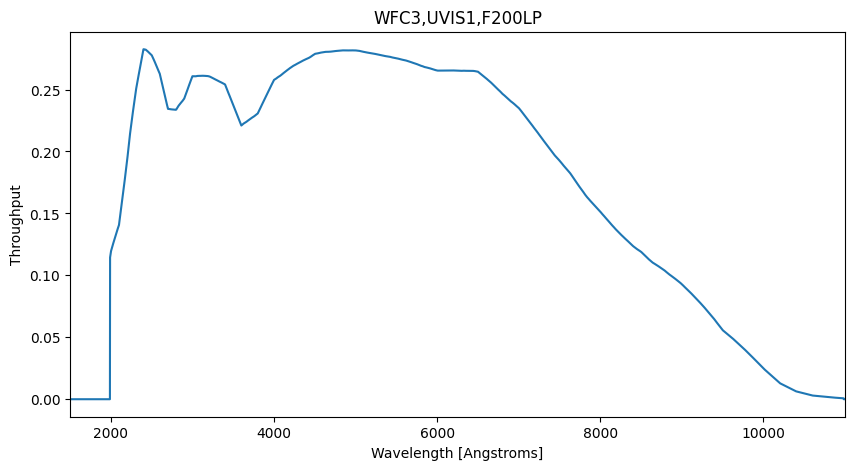

In [22]:
fig = plt.figure(figsize=(10, 5))
plt.plot(wl, tp)
plt.xlim(1500, 11000) 
plt.xlabel('Wavelength [Angstroms]')
plt.ylabel('Throughput')
plt.title('WFC3,UVIS1,F200LP')

To save the curve in an ascii table, simply pass the argument `save=True`:

In [23]:
calculate_bands(bp, save=True)

(<Quantity [  500.,  1000.,  1010., ..., 20002., 30000., 30010.] Angstrom>,
 <Quantity [0., 0., 0., ..., 0., 0., 0.]>)

To save curves for all obsmodes defined in [Section 3](#inps) in the input list, we can loop through detectors and filters.

In [24]:
for det in detectors:
    for filt in filtnames:
        obsmode = f'wfc3, {det}, {filt}'
        bp = stsyn.band(obsmode)
        calculate_bands(bp, save=True)

In addition, we'll create a directory called `obsmodes_curves` and move all the saved files to that directory.

In [25]:
! mkdir obsmodes_curves
! mv wfc3*txt obsmodes_curves
! ls obsmodes_curves

mkdir: cannot create directory ‘obsmodes_curves’: File exists


'wfc3, uvis1, f200lp.txt'  'wfc3, uvis1, f438w.txt'   'wfc3, uvis1, f645n.txt'
'wfc3, uvis1, f218w.txt'   'wfc3, uvis1, f467m.txt'   'wfc3, uvis1, f656n.txt'
'wfc3, uvis1, f225w.txt'   'wfc3, uvis1, f469n.txt'   'wfc3, uvis1, f657n.txt'
'wfc3, uvis1, f275w.txt'   'wfc3, uvis1, f475w.txt'   'wfc3, uvis1, f658n.txt'
'wfc3, uvis1, f280n.txt'   'wfc3, uvis1, f475x.txt'   'wfc3, uvis1, f665n.txt'
'wfc3, uvis1, f300x.txt'   'wfc3, uvis1, f487n.txt'   'wfc3, uvis1, f673n.txt'
'wfc3, uvis1, f336w.txt'   'wfc3, uvis1, f502n.txt'   'wfc3, uvis1, f680n.txt'
'wfc3, uvis1, f343n.txt'   'wfc3, uvis1, f547m.txt'   'wfc3, uvis1, f689m.txt'
'wfc3, uvis1, f350lp.txt'  'wfc3, uvis1, f555w.txt'   'wfc3, uvis1, f763m.txt'
'wfc3, uvis1, f373n.txt'   'wfc3, uvis1, f600lp.txt'  'wfc3, uvis1, f775w.txt'
'wfc3, uvis1, f390m.txt'   'wfc3, uvis1, f606w.txt'   'wfc3, uvis1, f814w.txt'
'wfc3, uvis1, f390w.txt'   'wfc3, uvis1, f621m.txt'   'wfc3, uvis1, f845m.txt'
'wfc3, uvis1, f395n.txt'   'wfc3, uvis1, f625w.txt' 

<a id="conclusions"></a>
## 8. Conclusions

Thank you for walking through this notebook. Now using WFC3 data, you should be more familiar with:

- Calculating zeropoints and other photometric properties using `stsynphot`.
- Creating, plotting, and saving 'total system throughput' tables.

#### Congratulations, you have completed the notebook!

<a id="resources"></a>
## Additional Resources
Below are some additional resources that may be helpful. Please send any questions through the [HST Helpdesk](https://stsci.service-now.com/hst).

- [WFC3 Website](https://www.stsci.edu/hst/instrumentation/wfc3)
- [WFC3 Instrument Handbook](https://hst-docs.stsci.edu/wfc3ihb)
- [WFC3 Data Handbook](https://hst-docs.stsci.edu/wfc3dhb)
    - see sections 9.5.2 for reference to this notebook
    
<a id="about"></a>
## About this Notebook

**Authors:** Varun Bajaj, Jennifer Mack; WFC3 Instrument Team

**Updated on:** 2024-03-18

<a id="cite"></a>
## Citations

If you use `numpy`, `astropy`, `synphot`, or `stsynphot` for published research, please cite the
authors. Follow these links for more information about citing the libraries below:

* [Citing `numpy`](https://numpy.org/citing-numpy/)
* [Citing `astropy`](https://www.astropy.org/acknowledging.html)
* [Citing `synphot`](https://synphot.readthedocs.io/en/latest/)
* [Citing `stsynphot`](https://stsynphot.readthedocs.io/en/latest/index.html)

<hr>
[Top of Page](#title)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 